The goal of this notebook is to organize the process of doing a regression analysis. The steps I see for the process are the following:  
1) Explore and prepare data  
2) Investigate/Engineer features  
3) Choose the model type(s) to test  
4) Test the model    
5) Iterate through steps 2-4 to improve the model  
6) Eventually give up trying to make the model better and be happy with the best one so far (because, lets face it, you're NEVER done tinkering with the model and features...)

I'm going to test this with the 2015 NYC Citibike data for NYC. I will try to predict the number of daily users with the info in the Citibike data and historical weather data from wunderground.com.

## Part I: Explore and Prepare Data

In [5]:
#Import some of the tools I know I will need:
import numpy as np
import pandas as pd
import requests
import zipfile
import io
from datetime import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

# Python 2 & 3 Compatibility
from __future__ import print_function, division

%matplotlib inline

Make a list of all the files for the year 2015:

In [3]:
file_num = ["%.2d" % (i+1) for i in range(12)]


Open them as pandas dataframes and append them to a list:

In [162]:
data_2015 = []
for number in file_num:
    zip_file = 'https://s3.amazonaws.com/tripdata/2015'+ number + '-citibike-tripdata.zip'
    print(zip_file)
    r = requests.get(zip_file)
    with zipfile.ZipFile(io.BytesIO(r.content)) as ar:
        csv_file = '2015' + number + '-citibike-tripdata.csv'
        data_2015.append(pd.read_csv(ar.open(csv_file)))

https://s3.amazonaws.com/tripdata/201501-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201502-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201503-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201504-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201505-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201506-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201507-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201508-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201509-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201510-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201511-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201512-citibike-tripdata.zip


Check which months have a different datetime format:

In [165]:
i=1
for df in data_2015:
    print( "month =", i)
    print( "starttime", df['starttime'][1])
    print( "stoptime", df['stoptime'][1])
    print ("shape", df.shape)
    i=i+1

month = 1
starttime 1/1/2015 0:02
stoptime 1/1/2015 0:08
shape (285552, 15)
month = 2
starttime 2/1/2015 0:00
stoptime 2/1/2015 0:07
shape (196930, 15)
month = 3
starttime 3/1/2015 0:01
stoptime 3/1/2015 0:14
shape (341826, 15)
month = 4
starttime 4/1/2015 00:00:52
stoptime 4/1/2015 00:10:31
shape (652390, 15)
month = 5
starttime 5/1/2015 00:00:28
stoptime 5/1/2015 00:25:52
shape (961986, 15)
month = 6
starttime 6/1/2015 0:00
stoptime 6/1/2015 0:05
shape (941219, 15)
month = 7
starttime 7/1/2015 00:00:06
stoptime 7/1/2015 00:05:29
shape (1085676, 15)
month = 8
starttime 8/1/2015 00:00:05
stoptime 8/1/2015 00:05:06
shape (1179044, 15)
month = 9
starttime 9/1/2015 00:00:00
stoptime 9/1/2015 00:02:45
shape (1289699, 15)
month = 10
starttime 10/1/2015 00:00:02
stoptime 10/1/2015 00:09:55
shape (1212277, 15)
month = 11
starttime 11/1/2015 00:00:01
stoptime 11/1/2015 00:18:15
shape (987245, 15)
month = 12
starttime 12/1/2015 07:38:15
stoptime 12/1/2015 07:49:39
shape (804125, 15)


Months 4,5,7,8,9,10,11,12 have a different date time format. Will need to convert all to datetime format seperately.

In [167]:
month = 0
for df in data_2015:
    month = month+1
    other_format = [4,5,7,8,9,10,11,12]
    if month in other_format:
        print(month)
        df['starttime'] = pd.to_datetime(df['starttime'], format = '%m/%d/%Y %H:%M:%S')
        df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%m/%d/%Y %H:%M:%S')
    else:
        print(month)
        df['starttime'] = pd.to_datetime(df['starttime'], format = '%m/%d/%Y %H:%M')
        df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%m/%d/%Y %H:%M')

1
2
3
4
5
6
7
8
9
10
11
12


Combine dataframes into one dataframe

In [168]:
trip_data = pd.concat(data_2015)

Pickle the dataframe so I dont have to load it again:

In [169]:
trip_data.to_pickle("raw_citibike_data.pkl")

Read in pickled df if needed:

In [757]:
trip_data = pd.read_pickle("/Users/torrie/Documents/Metis_Take_Home/raw_citibike_data.pkl")

In [758]:
trip_data = trip_data.reset_index()
trip_data = trip_data.drop('index', axis = 1)

In [759]:
trip_data.head(2)

tripduration           starttime            stoptime  start station id  \
0          1346 2015-01-01 00:01:00 2015-01-01 00:24:00               455   
1           363 2015-01-01 00:02:00 2015-01-01 00:08:00               434   

  start station name  start station latitude  start station longitude  \
0    1 Ave & E 44 St               40.750020               -73.969053   
1    9 Ave & W 18 St               40.743174               -74.003664   

   end station id          end station name  end station latitude  \
0             265  Stanton St & Chrystie St             40.722293   
1             482           W 15 St & 7 Ave             40.739355   

   end station longitude  bikeid    usertype  birth year  gender  
0             -73.991475   18660  Subscriber      1960.0       2  
1             -73.999318   16085  Subscriber      1963.0       1

In [760]:
print("There are",trip_data.shape[0],"trips logged in this dataset")

There are 9937969 trips logged in this dataset


Check for nulls:

In [761]:
trip_data.isnull().sum()

tripduration                     0
starttime                        0
stoptime                         0
start station id                 0
start station name               0
start station latitude           0
start station longitude          0
end station id                   0
end station name                 0
end station latitude             0
end station longitude            0
bikeid                           0
usertype                         0
birth year                 1311378
gender                           0
dtype: int64

Looks like only birth_year is missing data.

Check data types:

In [762]:
trip_data.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
dtype: object

In [763]:
trip_data.describe()

tripduration  start station id  start station latitude  \
count  9.937969e+06      9.937969e+06            9.937969e+06   
mean   9.680877e+02      6.181264e+02            4.073592e+01   
std    7.609485e+03      7.347459e+02            2.042297e-02   
min    6.000000e+01      7.200000e+01            4.064677e+01   
25%    3.890000e+02      3.140000e+02            4.072182e+01   
50%    6.290000e+02      4.320000e+02            4.073705e+01   
75%    1.049000e+03      5.020000e+02            4.075098e+01   
max    5.864661e+06      3.242000e+03            4.078721e+01   

       start station longitude  end station id  end station latitude  \
count             9.937969e+06    9.937969e+06          9.937969e+06   
mean             -7.398947e+01    6.105992e+02          4.073563e+01   
std               1.398510e-02    7.241606e+02          2.037340e-02   
min              -7.401713e+01    7.200000e+01          4.064677e+01   
25%              -7.399932e+01    3.120000e+02          4.072165e+01   
50%              -7.399021e+01    4.280000e+02          4.073653e+01   
75%              -7.398135e+01    4.990000e+02          4.075097e+01   
max              -7.392989e+01    3.242000e+03          4.078721e+01   

       end station longitude        bikeid    birth year        gender  
count           9.937969e+06  9.937969e+06  8.626591e+06  9.937969e+06  
mean           -7.398963e+01  1.945289e+04  1.976553e+03  1.068916e+00  
std             1.398808e-02  2.859060e+03  1.156820e+01  5.746586e-01  
min            -7.405044e+01  1.452900e+04  1.885000e+03  0.000000e+00  
25%            -7.399973e+01  1.698300e+04  1.969000e+03  1.000000e+00  
50%            -7.399054e+01  1.938700e+04  1.979000e+03  1.000000e+00  
75%            -7.398142e+01  2.210000e+04  1.986000e+03  1.000000e+00  
max            -7.392989e+01  2.476900e+04  1.999000e+03  2.000000e+00

Make a copy and drop items relating to specific trips rather than the day as a whole, i.e., any information that could not be known ahead of time and used to predict.


In [764]:
trip_data_model = trip_data.copy()
trip_data_model = trip_data_model.drop([u'tripduration', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'], axis = 1)
trip_data_model.columns

Index([u'starttime'], dtype='object')

## Part II) Investigate/Engineer features

In [765]:
#Add the day and the month as columns so they can be used as predictors
trip_data_model['day_of_week'] = trip_data_model['starttime'].dt.dayofweek
trip_data_model['month'] = trip_data_model['starttime'].dt.month
trip_data_model['date'] = trip_data_model['starttime'].dt.date

In [766]:
trip_data_model['Day_total'] = trip_data_model['month'].groupby(trip_data_model['date']).transform('count')

In [767]:
trip_data_model_f1 = trip_data_model.groupby(['date','month','day_of_week']).count().drop('starttime', axis = 1).reset_index()

Load in daily weather information from Wunderground.com:

In [768]:
weather_df= pd.read_excel('/Users/torrie/Documents/Metis_Take_Home/NY_weather.xlsx', skiprows=None) 

In [769]:
weather_df = weather_df.rename(columns = {'high hind':'wind max', 'Unnamed: 8':'Events', 'sum':'Precip(in)', 'Date':'date'})

In [770]:
weather_df = weather_df[weather_df['Day'] != 2015]
date_range = range(32)
weather_df = weather_df[weather_df['Day'].isin(date_range)]
weather_df = weather_df.drop(['wind max','gusts','Events','high Temp', 'temp low','Events'], axis = 1)
weather_df.head()

Day  temp avg  avg wind Precip(in)       date
0    1        34        17          0 2015-01-01
1    2        40        14          0 2015-01-02
2    3        39         9       0.94 2015-01-03
3    4        49        10       0.47 2015-01-04
4    5        37        20          0 2015-01-05

In [771]:
weather_df['date'] = pd.to_datetime(weather_df["date"], infer_datetime_format=False)

In [772]:
weather_df['Precip(in)'] = weather_df['Precip(in)'].replace('T',0.01)

In [773]:
weather_df['Precip_cat'] = 0
weather_df['Precip_cat'][weather_df['Precip(in)']>0.01] = 1

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [775]:
trip_data_model_f1['date'] = pd.to_datetime(trip_data_model_f1['date'])

In [776]:
all_data = pd.merge(weather_df, trip_data_model_f1, on = 'date')

In [777]:
all_data = all_data.drop(['date','Day'], axis = 1)
all_data.head()

temp avg  avg wind  Precip(in)  Precip_cat  month  day_of_week  Day_total
0        34        17        0.00           0      1            3       5317
1        40        14        0.00           0      1            4      11304
2        39         9        0.94           1      1            5       4478
3        49        10        0.47           1      1            6       7849
4        37        20        0.00           0      1            0      14506

In [778]:
print(all_data.describe())

         temp avg    avg wind  Precip(in)  Precip_cat       month  \
count  365.000000  365.000000  365.000000  365.000000  365.000000   
mean    56.389041   10.920548    0.105753    0.271233    6.526027   
std     18.268657    4.060902    0.296736    0.445206    3.452584   
min     12.000000    2.000000    0.000000    0.000000    1.000000   
25%     43.000000    8.000000    0.000000    0.000000    4.000000   
50%     58.000000   10.000000    0.000000    0.000000    7.000000   
75%     73.000000   13.000000    0.020000    1.000000   10.000000   
max     87.000000   28.000000    2.480000    1.000000   12.000000   

       day_of_week     Day_total  
count        365.0    365.000000  
mean           3.0  27227.312329  
std            2.0  13470.980912  
min            0.0   1107.000000  
25%            1.0  15234.000000  
50%            3.0  30295.000000  
75%            5.0  38285.000000  
max            6.0  52706.000000  


### Check for multicolinearity  
If a high degree of multicollinearity exists, either  
a) Use a method that handles collinearity  
b) Remove collinear features  
c) Transform features

In [779]:
#Print the pearson's correlation coefficient for each of the features

print(all_data.corr())

             temp avg  avg wind  Precip(in)  Precip_cat     month  \
temp avg     1.000000 -0.332309   -0.017381   -0.050841  0.494853   
avg wind    -0.332309  1.000000    0.032549   -0.001724 -0.268393   
Precip(in)  -0.017381  0.032549    1.000000    0.571675 -0.012777   
Precip_cat  -0.050841 -0.001724    0.571675    1.000000 -0.019797   
month        0.494853 -0.268393   -0.012777   -0.019797  1.000000   
day_of_week -0.017068 -0.019957   -0.014767   -0.052451 -0.009549   
Day_total    0.785300 -0.345205   -0.244702   -0.290455  0.660832   

             day_of_week  Day_total  
temp avg       -0.017068   0.785300  
avg wind       -0.019957  -0.345205  
Precip(in)     -0.014767  -0.244702  
Precip_cat     -0.052451  -0.290455  
month          -0.009549   0.660832  
day_of_week     1.000000  -0.172432  
Day_total      -0.172432   1.000000  


In [780]:
print(all_data.cov())

                  temp avg      avg wind  Precip(in)   Precip_cat  \
temp avg        333.743836    -24.653071   -0.094222    -0.413503   
avg wind        -24.653071     16.490923    0.039222    -0.003116   
Precip(in)       -0.094222      0.039222    0.088052     0.075523   
Precip_cat       -0.413503     -0.003116    0.075523     0.198209   
month            31.212374     -3.763036   -0.013090    -0.030431   
day_of_week      -0.623626     -0.162088   -0.008764    -0.046703   
Day_total    193259.856179 -18884.222369 -978.150346 -1741.966815   

                    month  day_of_week     Day_total  
temp avg        31.212374    -0.623626  1.932599e+05  
avg wind        -3.763036    -0.162088 -1.888422e+04  
Precip(in)      -0.013090    -0.008764 -9.781503e+02  
Precip_cat      -0.030431    -0.046703 -1.741967e+03  
month           11.920337    -0.065934  3.073510e+04  
day_of_week     -0.065934     4.000000 -4.645662e+03  
Day_total    30735.098991 -4645.662088  1.814673e+08  


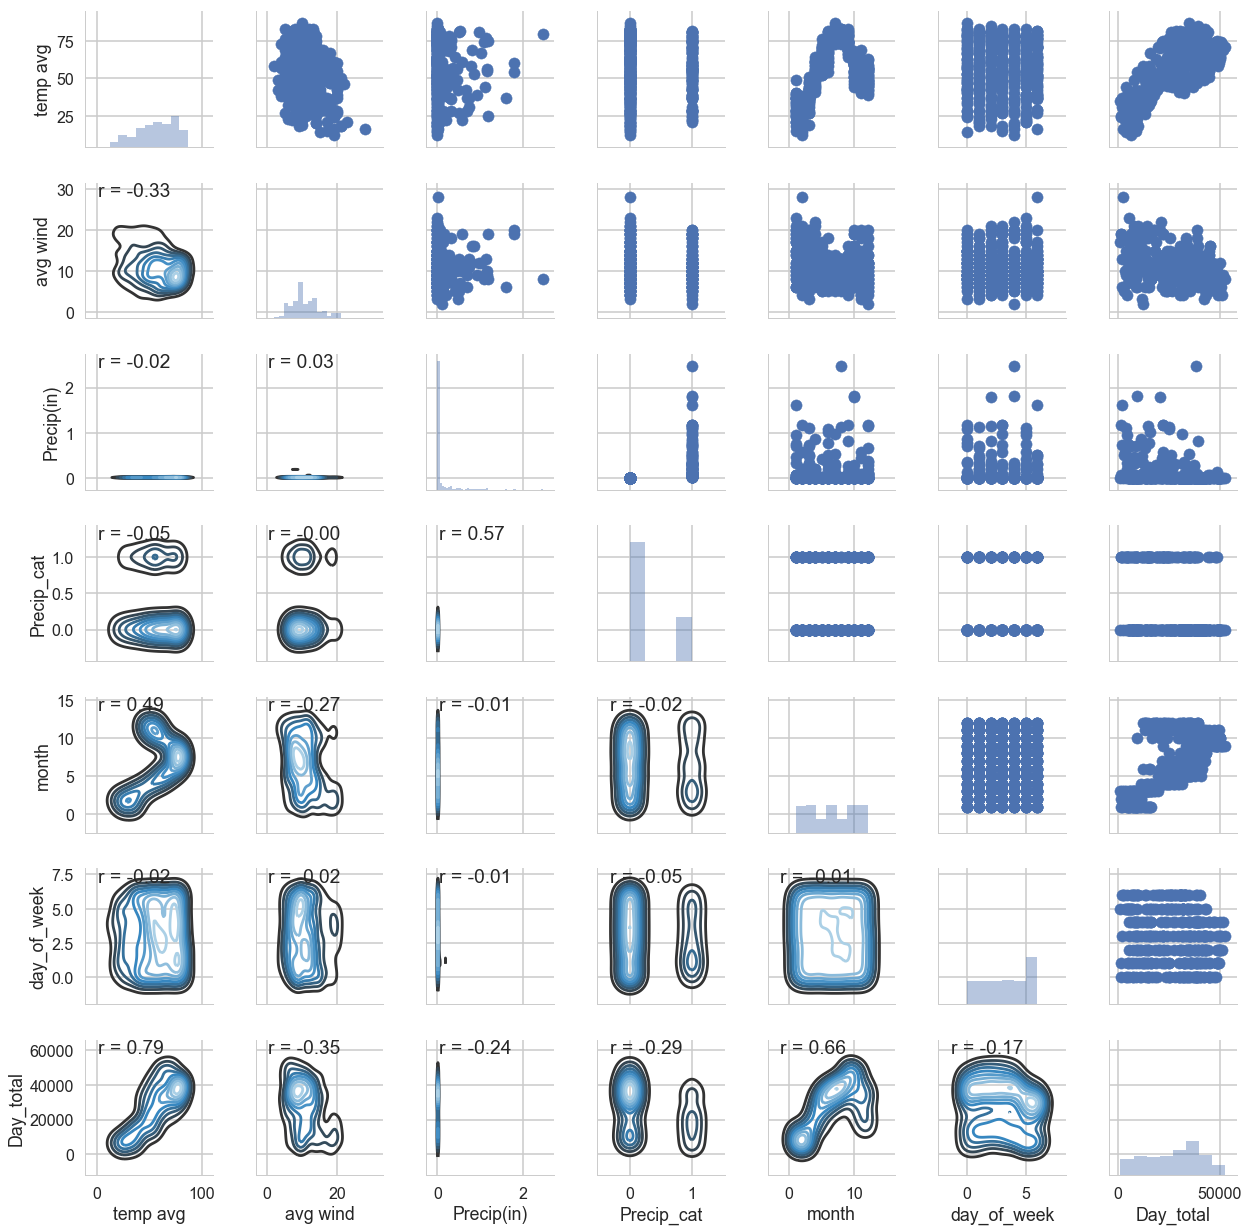

In [781]:
# Make a pairplot with scatterplots, histograms, and a density plot for each variables. 
# This helps us see what the data distribution is like and what our distributions look like
# Correlation coefficients are also printed on each plot
# The info can be used to determine if features need to be transformed and to identify collinear features

from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(all_data)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.distplot, kde=False)
g.map_lower(corrfunc);

The month and the average temperature look to be correlated, so I will test with both variables and with only average temperature.

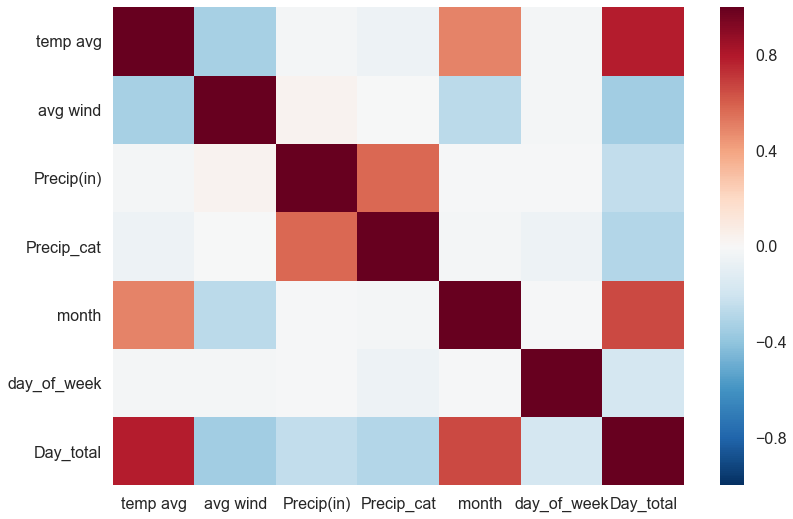

In [782]:
sns.heatmap(all_data.corr());


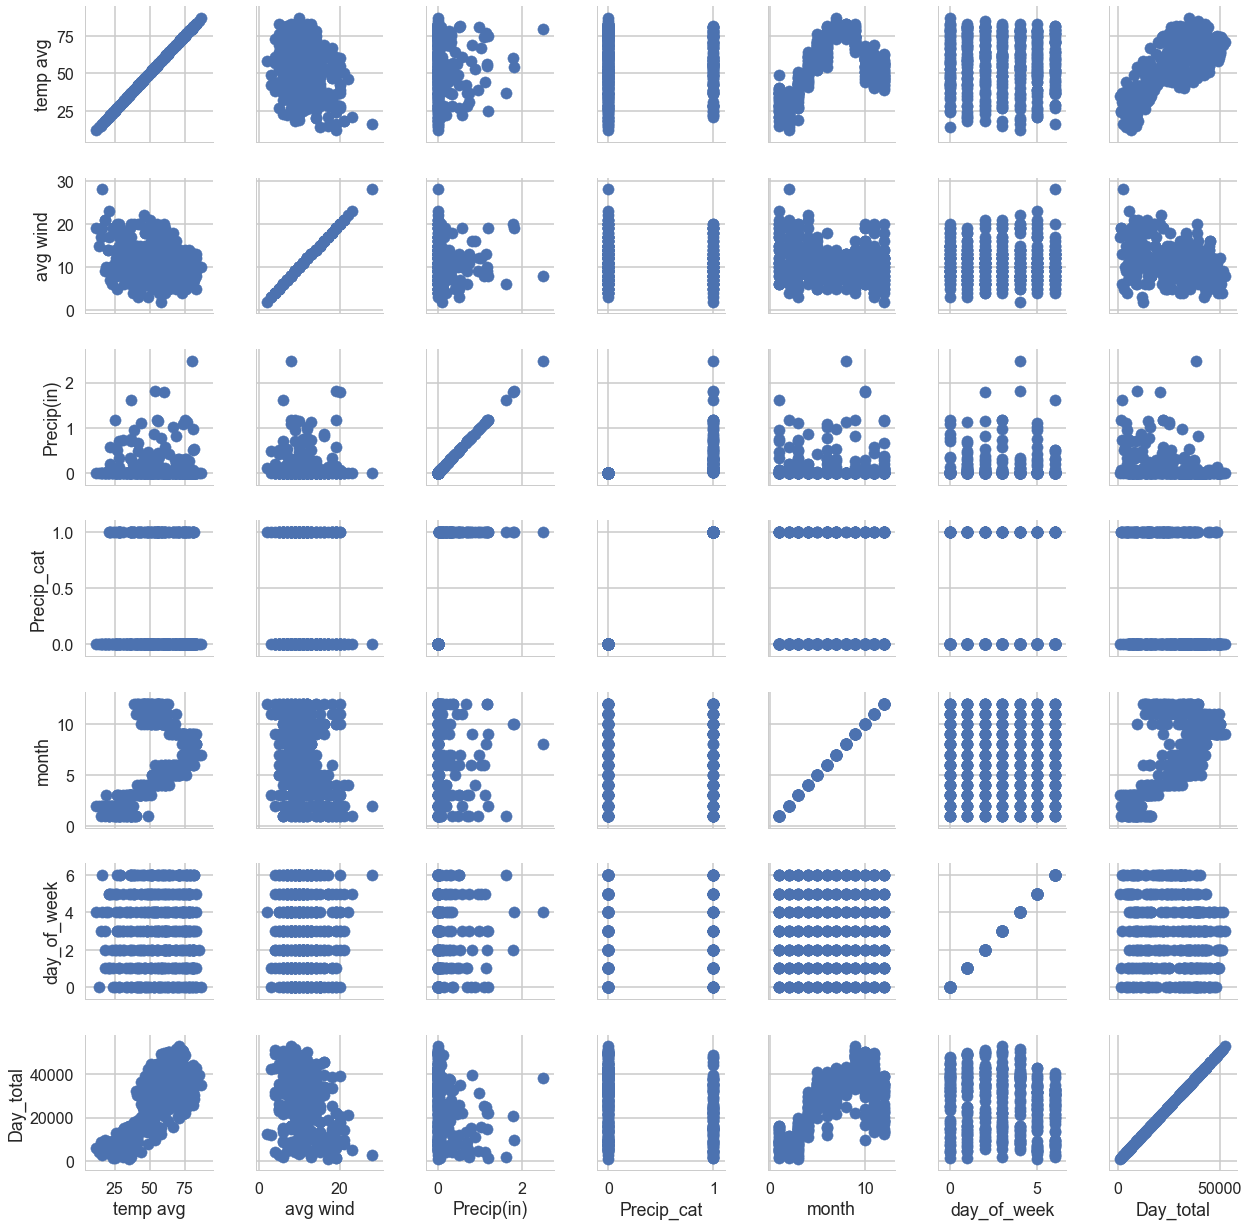

In [783]:
g = sns.PairGrid(all_data)
g.map(plt.scatter);

From the heatmap it is clear that the average temperature and the total daily riders are strongly correlated. 

This checks the variance inflation factor (VIF) of each feature. The VIF is: (fill this in when you figure that out!)

(Code was taken from here: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python)

In [784]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh):
    variables = range(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            print('VIF =', vif)
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]


calculate_vif_(all_data, 10.0)

dropping 'temp avg' at index: 0
VIF = [30.077852567627289, 4.3399559223794117, 1.7678594467759825, 2.2730381137702489, 9.2775402033813492, 3.4422093387469204, 28.440092359596488]
Remaining variables:
Index([   u'avg wind',  u'Precip(in)',  u'Precip_cat',       u'month',
       u'day_of_week',   u'Day_total'],
      dtype='object')


avg wind  Precip(in)  Precip_cat  month  day_of_week  Day_total
0          17        0.00           0      1            3       5317
1          14        0.00           0      1            4      11304
2           9        0.94           1      1            5       4478
3          10        0.47           1      1            6       7849
4          20        0.00           0      1            0      14506
5           9        0.07           1      1            1       8739
6          21        0.00           0      1            2       9646
7          17        0.00           0      1            3       8779
8          20        0.07           1      1            4       7930
9          17        0.00           0      1            5       6109
10         11        0.00           0      1            6       7467
11          6        0.70           1      1            0       8645
12         15        0.00           0      1            1      12797
13         12        0.00           0      1            2      13086
14         10        0.00           0      1            3      14075
15         18        0.00           0      1            4      13843
16         11        0.00           0      1            5       7491
17          6        1.62           1      1            6       1795
18         15        0.01           0      1            0      10710
19         12        0.01           0      1            1      16129
20          6        0.01           0      1            2      15234
21          8        0.00           0      1            3      15864
22         11        0.01           0      1            4      15737
23         11        0.75           1      1            5       4814
24         15        0.00           0      1            6       9379
25         18        0.33           1      1            0       4141
26         19        0.06           1      1            1       1214
27         14        0.00           0      1            2       5401
28          8        0.01           0      1            3       8870
29         19        0.04           1      1            4       9015
..        ...         ...         ...    ...          ...        ...
335         5        0.12           1     12            2      23782
336        16        0.01           0     12            3      33917
337        10        0.00           0     12            4      34737
338         5        0.00           0     12            5      26358
339         6        0.00           0     12            6      24943
340         8        0.00           0     12            0      34139
341         8        0.00           0     12            1      35614
342         8        0.00           0     12            2      35306
343         7        0.00           0     12            3      39099
344         6        0.00           0     12            4      39060
345         4        0.01           0     12            5      31957
346         7        0.01           0     12            6      32001
347        11        0.36           1     12            0      32518
348        18        0.09           1     12            1      38661
349         9        0.05           1     12            2      35643
350         9        1.17           1     12            3      21961
351        14        0.01           0     12            4      30704
352        20        0.00           0     12            5      17778
353        12        0.00           0     12            6      17030
354        12        0.00           0     12            0      29800
355         9        0.19           1     12            1      22941
356        10        1.16           1     12            2      14817
357        11        0.02           1     12            3      18447
358         2        0.10           1     12            4      12333
359        11        0.01           0     12            5      13914
360        12        0.08           1     12            6      13177
361

### Check the distribution of the target variable(s)    

Use Seaborn to make a histogram of the number of trips/day. 

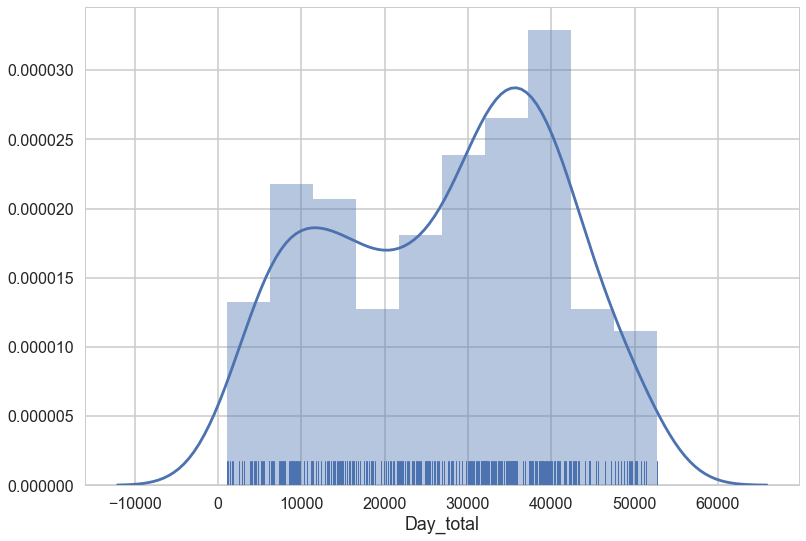

In [785]:
# This is the kde and histogram
sns.distplot(all_data.Day_total, bins = 10, rug=True);

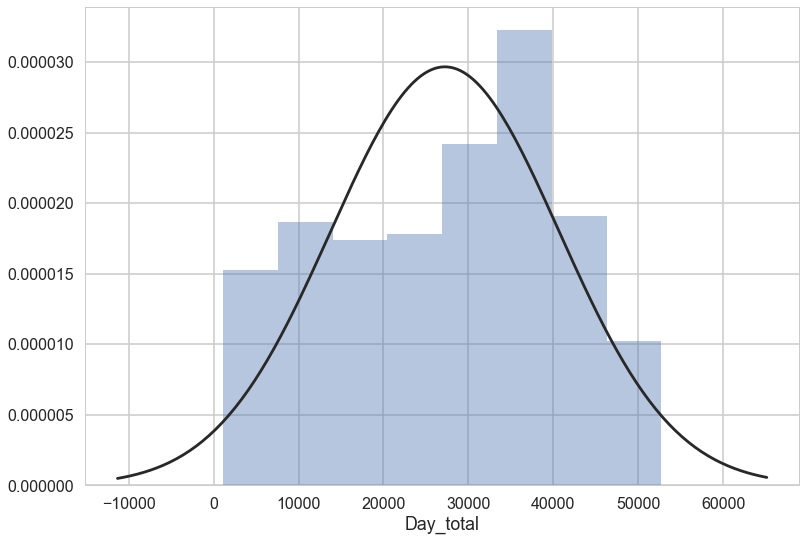

In [786]:
# This is the histogram with a normal distribution plotted. Clearly, the distribution is not normal.
sns.distplot(all_data.Day_total, kde=False, fit=stats.norm);

The distribution looks somewhat bimodal and definitely not normal. We can check a qq plot to see how poorly it fits wiat a normal distribution:

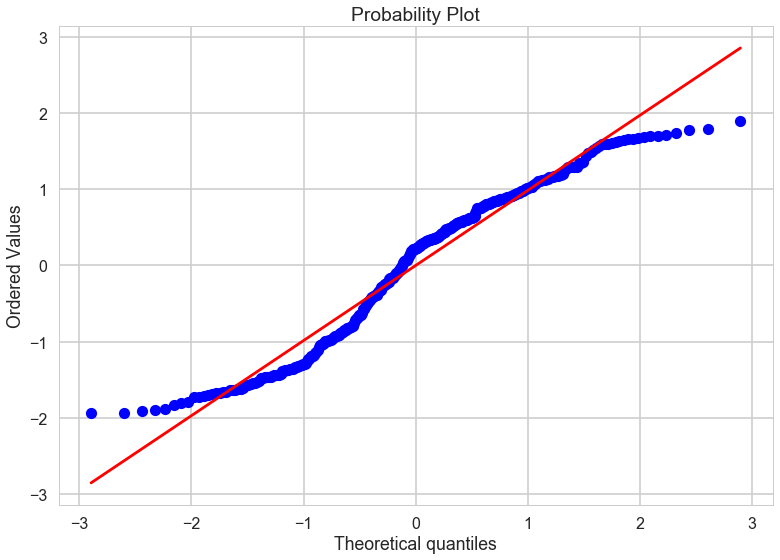

In [787]:
import numpy as np 
import pylab 
import scipy.stats as stats

obs = all_data.Day_total
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm", plot=pylab)
pylab.show()


We have a better fit with the uniform data diatribution, but still not great:

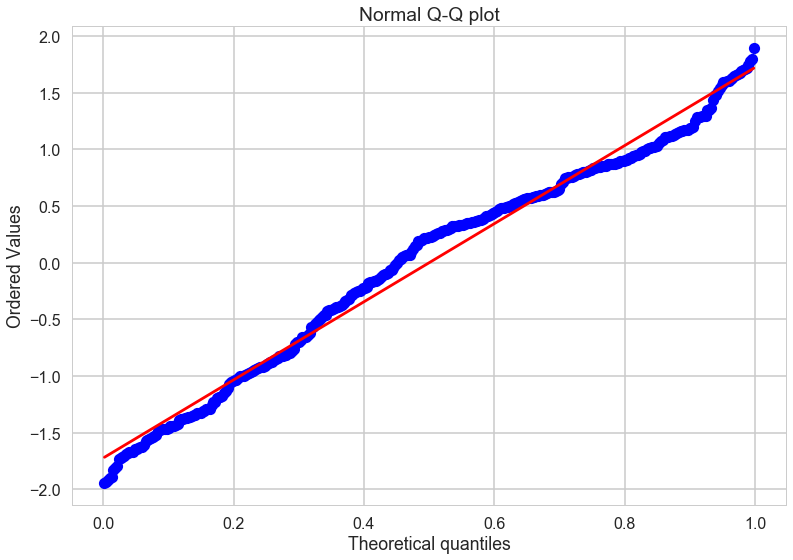

In [788]:
obs = all_data.Day_total
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="uniform", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()
#print(z)

I'd like to figure out what is causing that bimodal distribution. My guess is that week day and weekend traffic have two different peak sizes. Or summer vs winter. I'll add weekend/weekday and the seasons to the data frame to be able to look at where they fall in the distribution. 

In [789]:
all_data['day_type'] = 0
all_data['day_type'][all_data['day_of_week']<5] = 1
all_data['season'] = "summer"
all_data['season'][all_data['month']<5] = 'winter'
all_data['season'][all_data['month']>10] = 'winter'

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


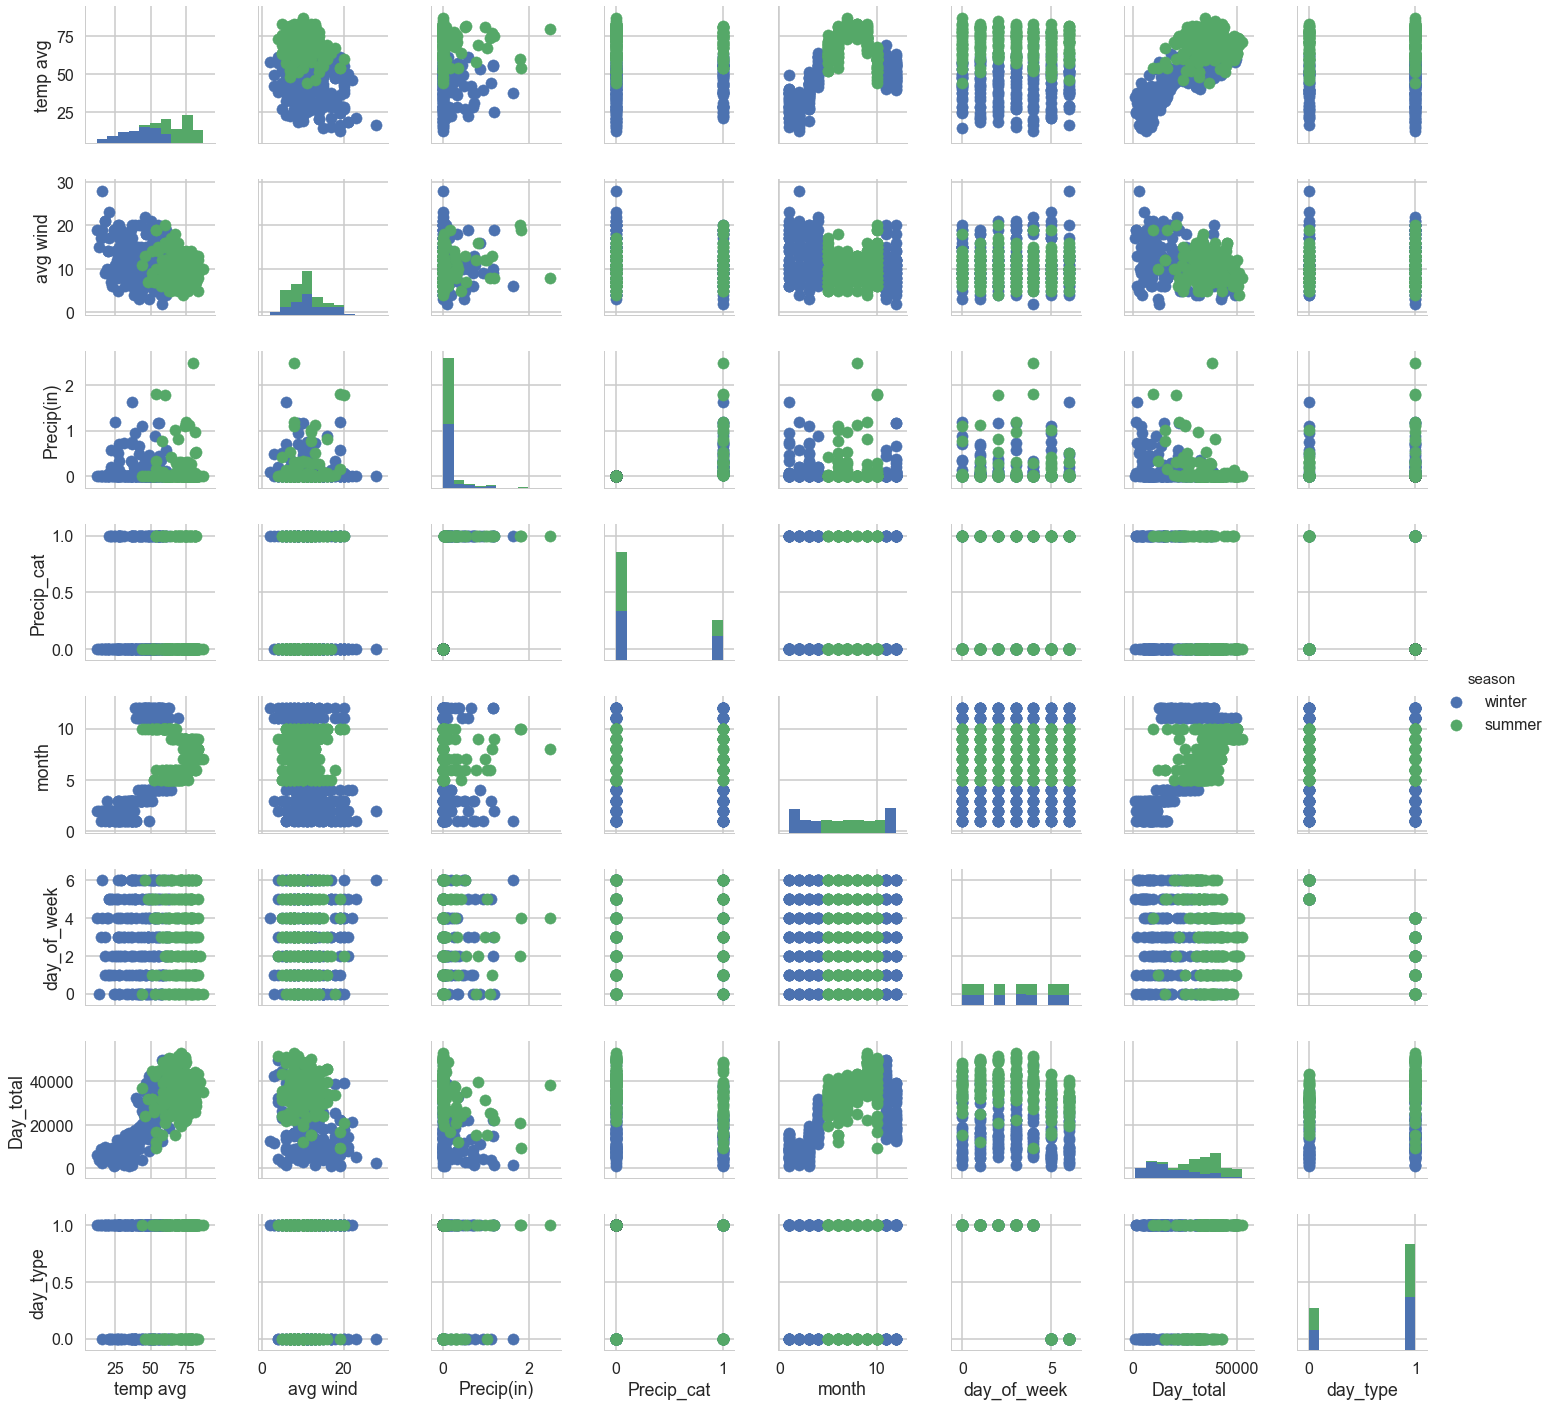

In [790]:
g = sns.PairGrid(all_data, hue="season")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

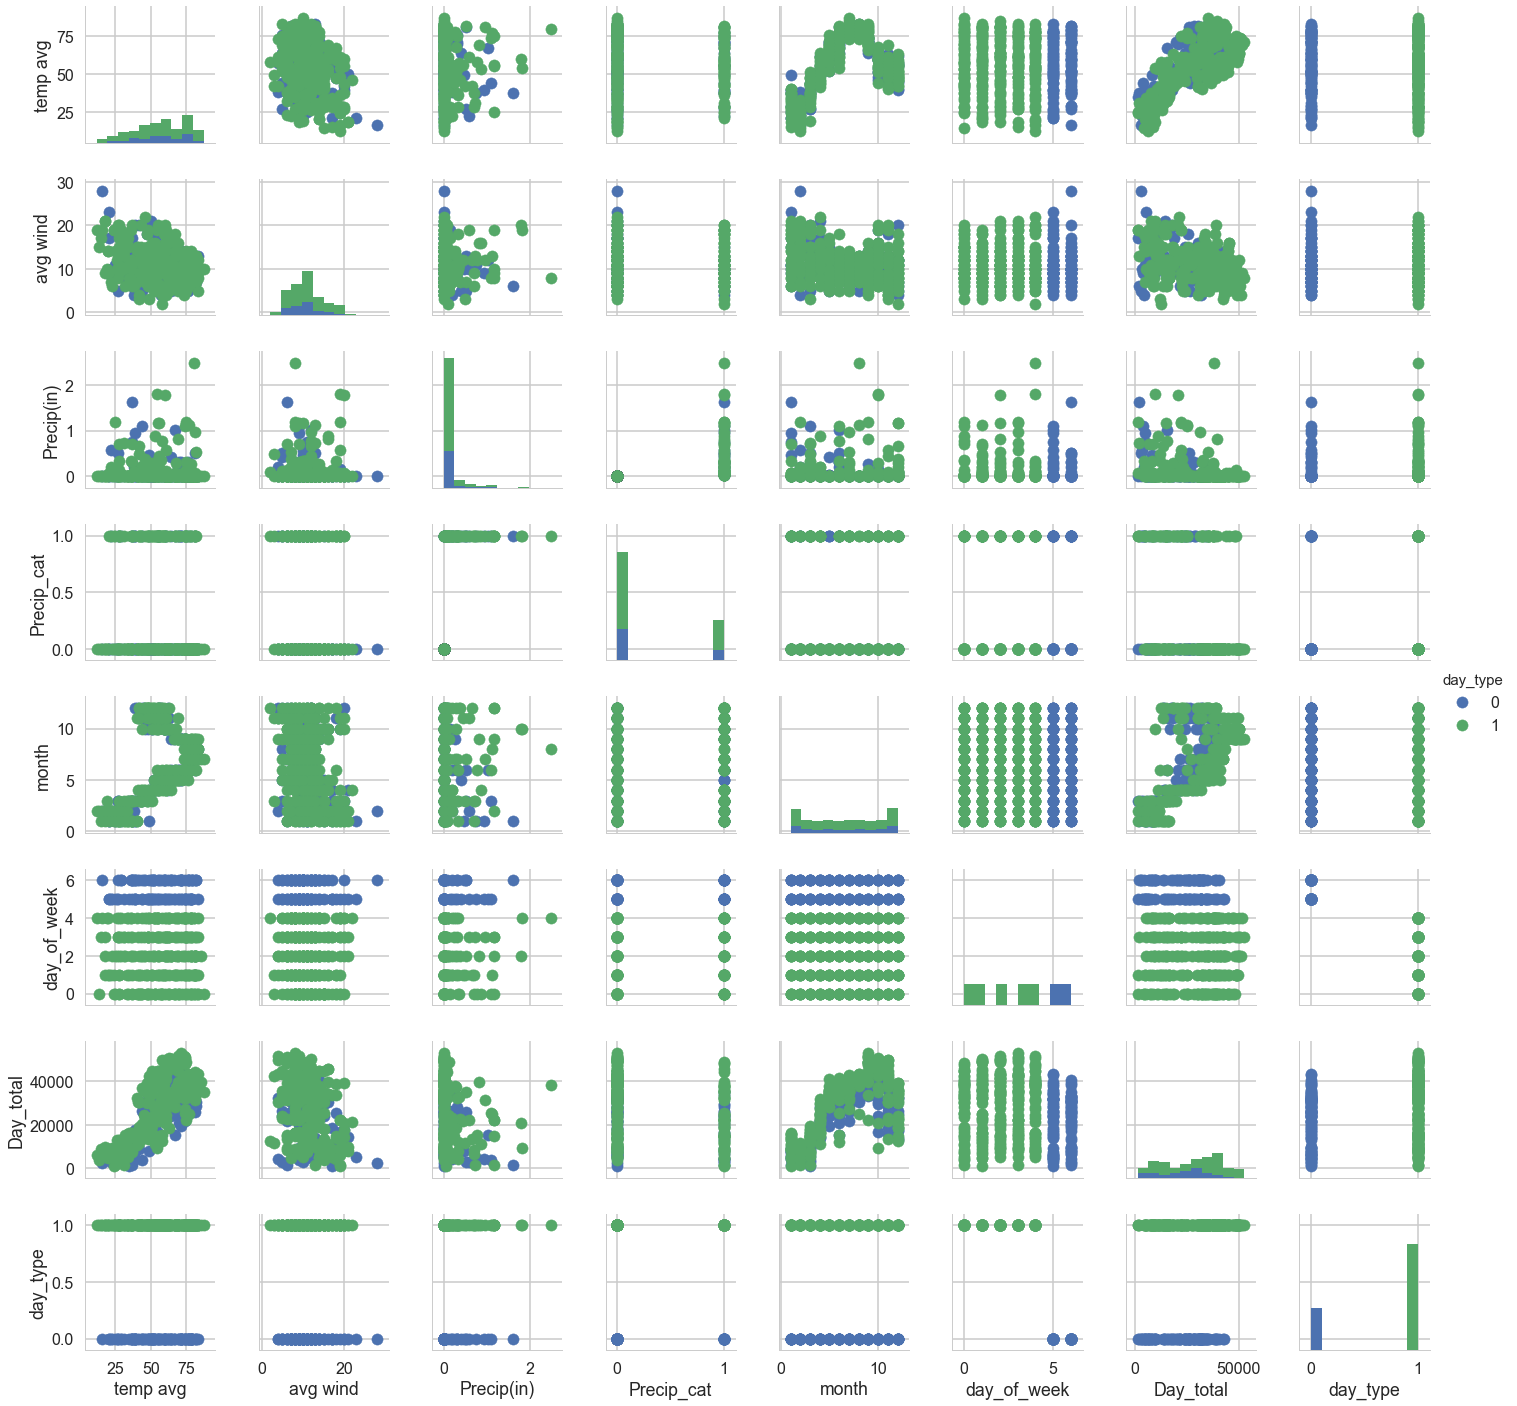

In [791]:
g = sns.PairGrid(all_data, hue="day_type")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

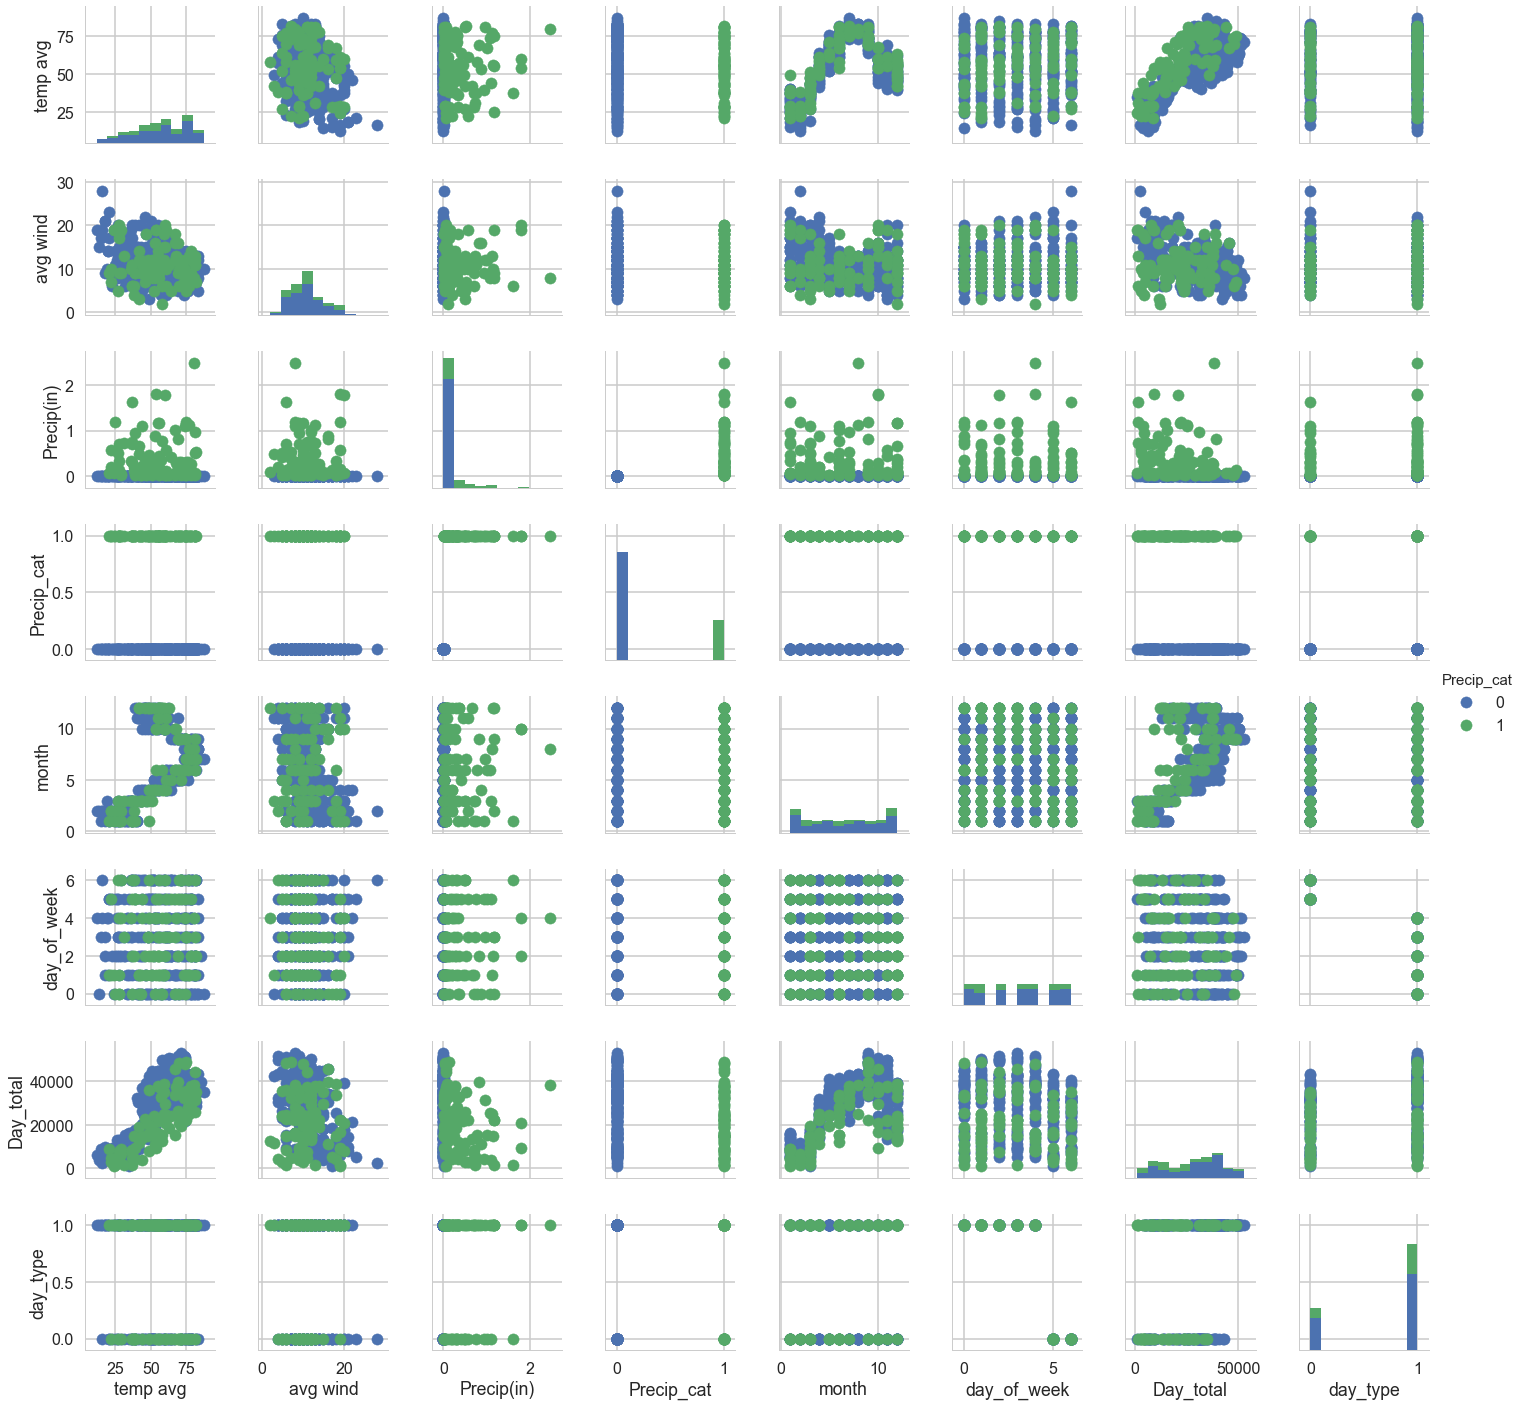

In [792]:
g = sns.PairGrid(all_data, hue ="Precip_cat")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

The weekend/weekday theory is clearly not correct. I'll drop that column.
However, the season explanation for the bimodal distribution is interesting. I'll look closer. 

In [793]:
all_data=all_data.drop('day_type', axis =1)

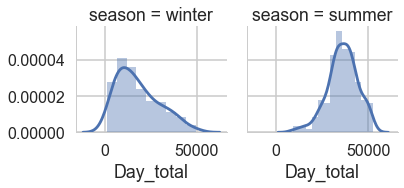

In [794]:
g = sns.FacetGrid(all_data, col="season")
#g.map(plt.hist, "Day_total");
g.map(sns.distplot, "Day_total");

In this case, if we divide the data into two parts based on the season, then we may be able to get a better model for each season becasue the data can be better approximated with a normal/skewed/lognormal distribution. These can be transformed to normal-ish, unlike a bimodal distribution.

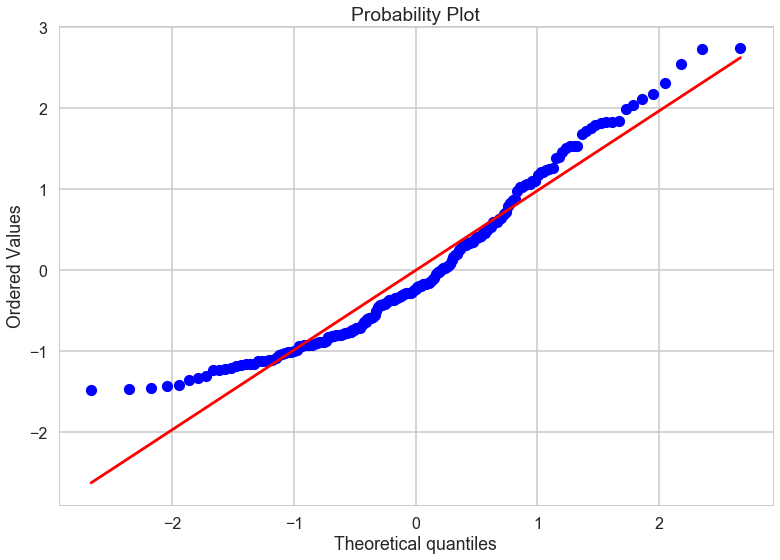

In [795]:
obs = all_data.Day_total[all_data.season == 'winter']
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm",plot=pylab)
pylab.show()


In [796]:
all_data['log_Day_total'] = np.log(all_data['Day_total'])

In [797]:
all_data['sqrt_Day_total'] = (all_data['Day_total'])**0.5

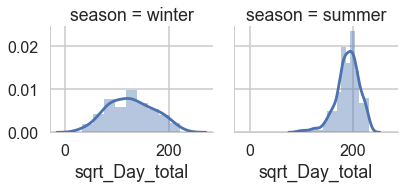

In [798]:
g = sns.FacetGrid(all_data, col="season")
#g.map(plt.hist, "Day_total");
g.map(sns.distplot, "sqrt_Day_total");

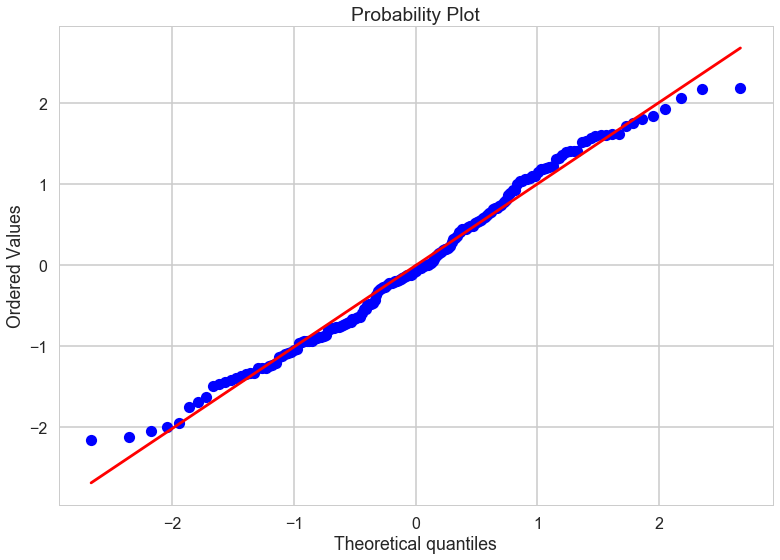

In [799]:
#Check the distribution of the sqrt for the winter distribution

obs = all_data.sqrt_Day_total[all_data.season == 'winter']
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm",plot=pylab)
pylab.show()

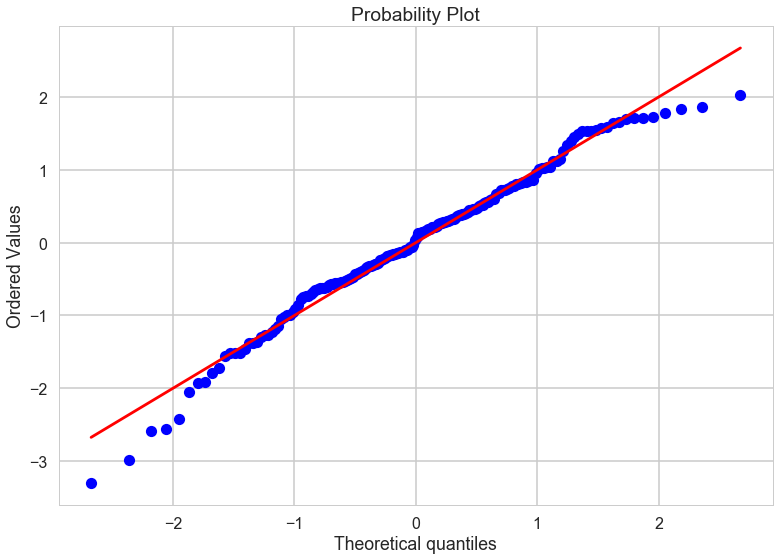

In [802]:
obs = all_data.Day_total[all_data.season == 'summer']
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm", plot=pylab)
pylab.show()


It looks like we could separate the distribution into the two parts, summer and winter. If we transform the winter data with a square root we can get a more normal distribution for that data as well. 

### Remove Outliers

First, just check as scatterplot of the data to see if there are any obvious outliers

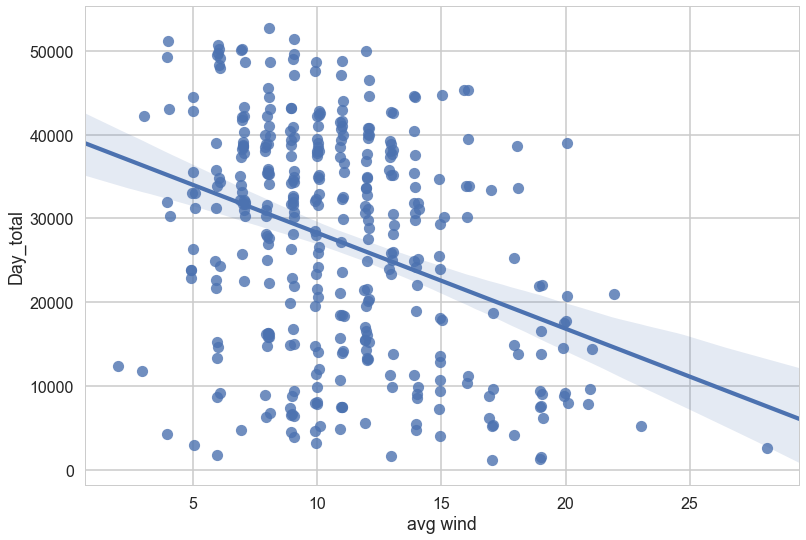

In [803]:
ax = sns.regplot(y=all_data.Day_total, x=all_data['avg wind'], data=all_data, x_jitter=.1)


Nothing is jumping out as a crazy outlier in the above plot.  
Try a boxplot to see if anything shows up in that.

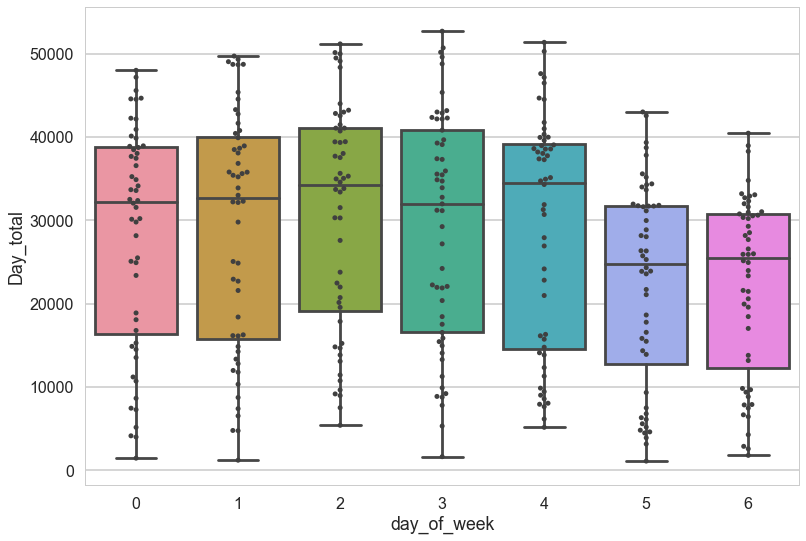

In [804]:
sns.set_context("poster")
sns.set_style("whitegrid")

ax = sns.boxplot(y="Day_total", x="day_of_week", data=all_data)
ax = sns.swarmplot(y="Day_total", x="day_of_week", data=all_data, color=".25")

#sns.despine(offset=10, trim=True);

There are no outliers if we look at the entire dataset together.  

What if we look at the seasons separately:

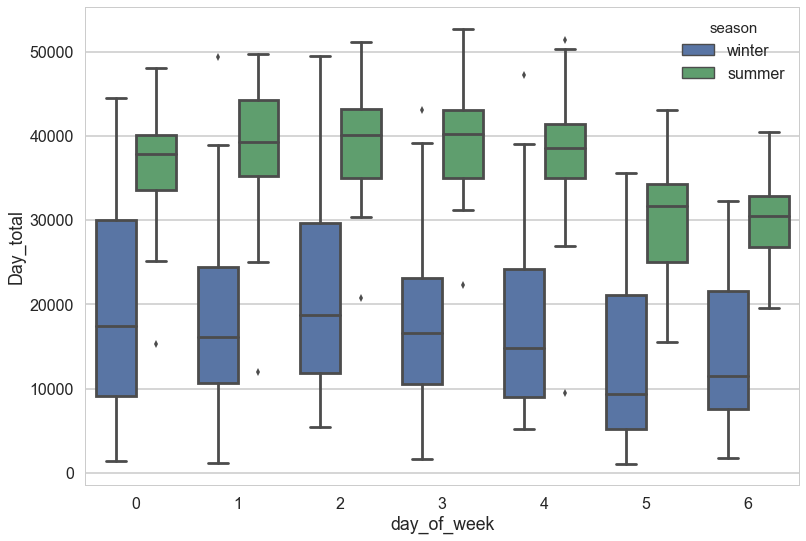

In [805]:
sns.set_context("poster")
sns.set_style("whitegrid")

ax = sns.boxplot(y="Day_total", x="day_of_week", data=all_data, hue = "season")

There are a few outliers here, but lets check and see how many show up in our transformed variables.

Winter Data


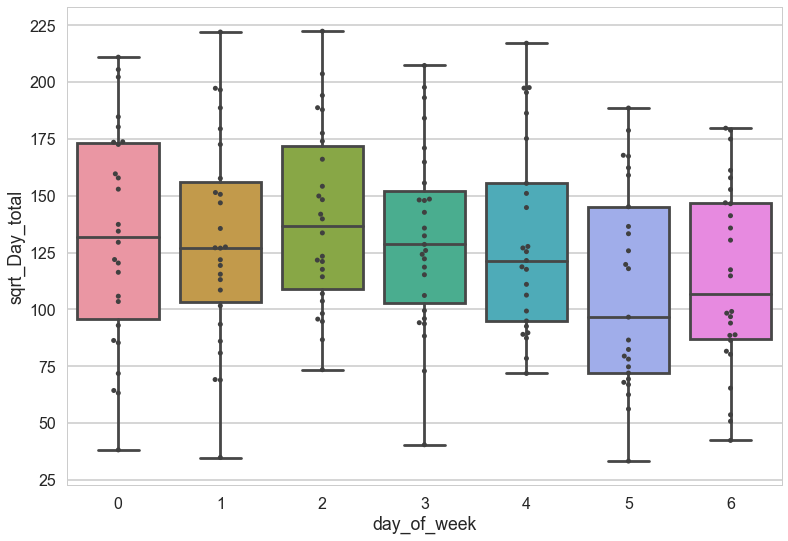

In [806]:
sns.set_context("poster")
sns.set_style("whitegrid")
print("Winter Data")
ax = sns.boxplot(y="sqrt_Day_total", x="day_of_week", data=all_data[all_data['season'] == 'winter'])
ax = sns.swarmplot(y="sqrt_Day_total", x="day_of_week", data=all_data[all_data['season'] == 'winter'],color=".25" )

Summer Data


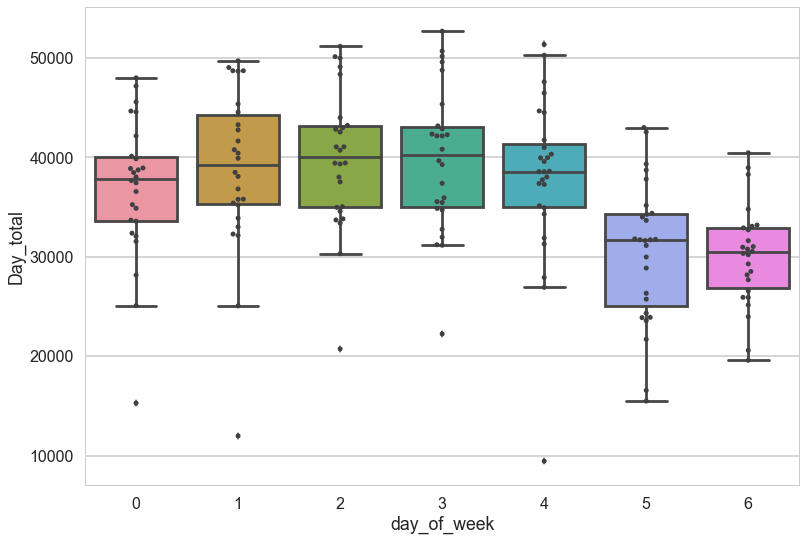

In [807]:
sns.set_context("poster")
sns.set_style("whitegrid")
print("Summer Data")
ax = sns.boxplot(y="Day_total", x="day_of_week", data=all_data[all_data['season'] == 'summer'])
ax = sns.swarmplot(y="Day_total", x="day_of_week", data=all_data[all_data['season'] == 'summer'],color=".25" )

I would like to note that I could also use matplotlib and pandas but its not nearly as pretty:

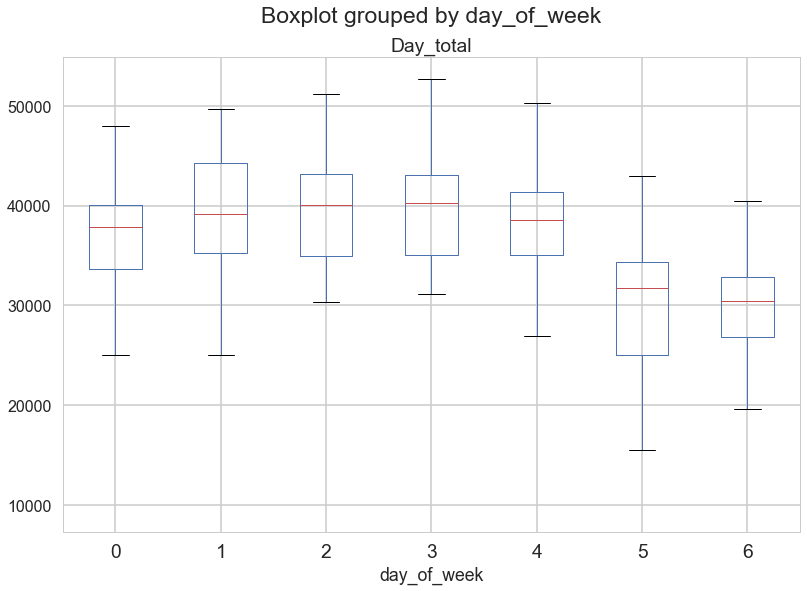

In [809]:
all_data[all_data['season'] == 'summer'].boxplot(column = "Day_total", by='day_of_week')


To find the outliers in the dataframe I need to find the quartile values and calculate the IQR (the distance between 25% and 75%). The Tukey boxplot calls any data point outside the region of 1.5IQR less than the lower quartile (25%) or greater than 1.5IQR greater than the upper quartile (75%) an outlier. The seaborn plot uses these criteria, so that is what I would use it for analysis. 

In [810]:
all_data_out = all_data.copy()
drop_list = []
for day in range(6):
    IQR = 1.5*(quartiles[day][6] - quartiles[day][4])
    upper_IQR = quartiles[day][6] + IQR
    lower_IQR = quartiles[day][4] - IQR
    drop_low = all_data_out[(all_data_out['season'] == 'summer') & (all_data_out['day_of_week'] == day) & (all_data_out['Day_total'] < lower_IQR)].index.tolist()
    drop_list.extend(drop_low) 
    drop_high = all_data_out[(all_data_out['season'] == 'summer') & (all_data_out['day_of_week'] == day) & (all_data_out['Day_total'] > upper_IQR)].index.tolist()
    drop_list.extend(drop_high) #all_data_out = all_data_out.drop(all_data_out.index[drop_high])
print(drop_list)

[151, 152, 300, 252, 274, 267]


Now that we have identified the points that are outliers we should take a look at them to see if there are any red flags (erroneous data, etc.).

In [811]:
all_data.iloc[drop_list]

temp avg  avg wind  Precip(in)  Precip_cat  month  day_of_week  \
151        58        12        0.78           1      6            0   
152        54        10        0.34           1      6            1   
300        60        20        1.79           1     10            2   
252        75         8        1.18           1      9            3   
274        54        19        1.81           1     10            4   
267        69         9        0.00           0      9            4   

     Day_total  season  log_Day_total  sqrt_Day_total  
151      15283  summer       9.634496      123.624431  
152      11984  summer       9.391328      109.471457  
300      20736  summer       9.939627      144.000000  
252      22253  summer      10.010232      149.174395  
274       9444  summer       9.153135       97.180245  
267      51368  summer      10.846771      226.645097

There is nothing about the conditions of these data points that makes them stand out as different from the rest. They seem like they are within the spectrum of reasonable conditions. Some days are rainy, some are cool but they all seem like reasonable days to ride a bike! As such, I am not convinced that they should be dropped from the analysis.  
But, if I wanted to, this is how I would do it:

In [812]:
all_data_out = all_data_out.drop(all_data_out.index[drop_list])

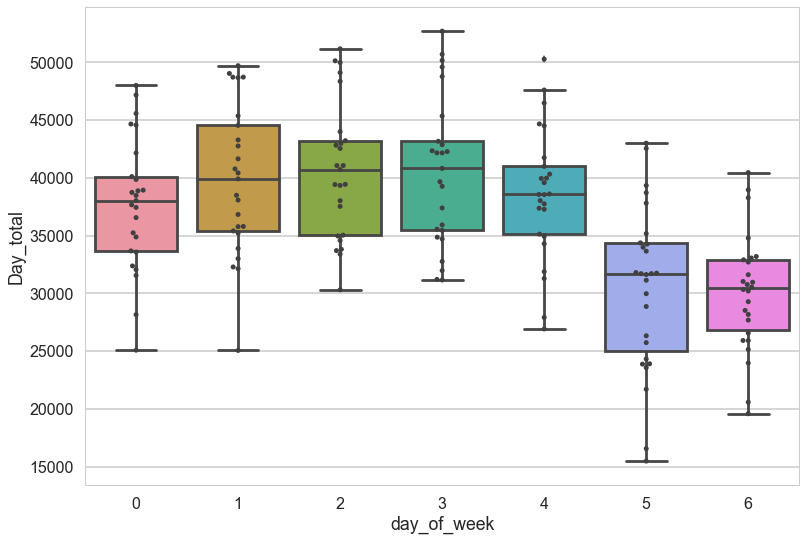

In [813]:
sns.set_context("poster")
sns.set_style("whitegrid")

ax = sns.boxplot(y="Day_total", x="day_of_week", data=all_data_out[all_data_out['season'] == 'summer'])
ax = sns.swarmplot(y="Day_total", x="day_of_week", data=all_data_out[all_data_out['season'] == 'summer'],color=".25" )

### Things to check for in addition to the above:  
Sample size big enough?  
Interactions?  

## Part III) Choose the model type(s) to test


In this case I am know I am doing a multiple linear regression model because I am looking to explain one continuous dependent variable with multiple independent variables. I have several options for the types of regression model and tools to use. 
I want to cross validation and regularization to prevent overfitting, so I will look at Ridge regression, Lasso regression and elastic net regression. Since there is some degree of collinearity, I have a slight expectation that ridge regression may give a better prediction becasue it is more robust to collinearity. I'll fit the model to dat a with and without the collinear data to see which produces a better model.   
I'm also checking LinearRegression() and HuberRegressor() as comparisons to the regularized, cross-validated methods. 

## Part IV) Test the model

First, try model with all data. Then try seperate model with the "summer" and "winter" data. 

Just a super simple OLS model from skleran. No cross validation or regularization:

In [816]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn import preprocessing


X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total',u'Precip_cat'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=1)

# Create model
model = sm.OLS(y_train, X_train)

# Fit model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Day_total   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     554.8
Date:                Wed, 16 Aug 2017   Prob (F-statistic):          2.65e-129
Time:                        14:05:37   Log-Likelihood:                -2551.1
No. Observations:                 244   AIC:                             5112.
Df Residuals:                     239   BIC:                             5130.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          3.485e+04   1616.991     21.550      0.000      3.17e+04   3.8e+04
x2          -2.36e+04   3762.494     -6.273      0.000      -3.1e+04 -1.62e+04
x3         -7.983e+05   1.06e+05     -7.511      0.000     -1.01e+06 -5.89e+05
x4          5.395e+04   9782.639      5.515      0.000      3.47e+04  7.32e+04
x5         -9.448e+04    1.3e+04     -7.242      0.000      -1.2e+05 -6.88e+04
==============================================================================
Omnibus:                        2.534   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                2.123
Skew:                          -0.108   Prob(JB):                        0.346
Kurtosis:                       2.597   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [817]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Fit the model to the train dataset
fit = lr.fit(X_train, y_train)

# Print out the R^2 for the model against the test dataset
print("Test:", lr.score(X_test,y_test))

Test: 0.653268879786


Of course, when building a predictive model it's best practice to use regularization and cross validation.  
Since we know we have some degree of collineraity we should try out ridge regression with cross-validation:

In [820]:
from sklearn.linear_model import RidgeCV

X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'Precip_cat'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)


reg = RidgeCV(alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])

fit = reg.fit(X_train, y_train)


# Print out the R^2 for the model against the test dataset
print("Train:", reg.score(X_train,y_train))
print("Test:", reg.score(X_test,y_test))

print(reg.alpha_)


Train: 0.687328842791
Test: 0.60443866798
0.001


This model is OK, but not great.  
One thing we can check to investigate model performance is residuls.  I want to know if they are normally distributed, homoscedastic, and centered around zero.   
If I want to make a redidual scatterplot (including a trendline to see if the there is any trend with the values) with matplotlib I could use the code below:

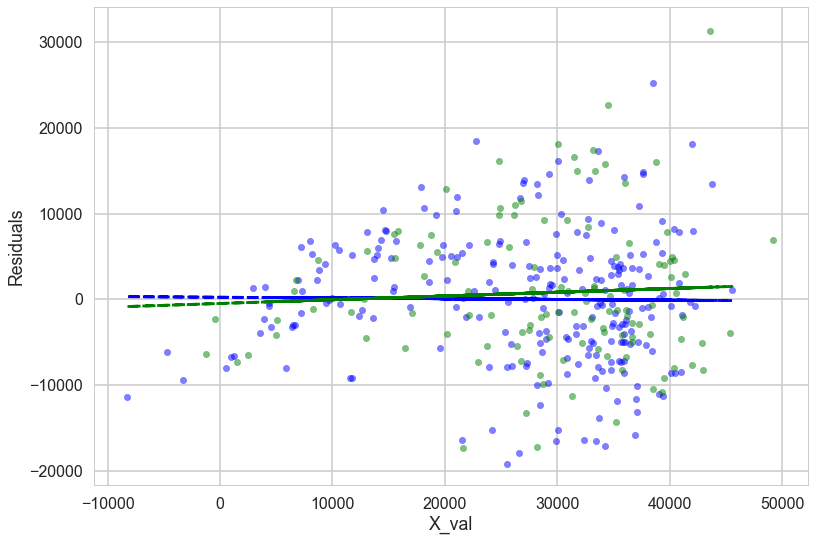

In [447]:
xtr = reg.predict(X_train)
ytr = reg.predict(X_train)-y_train
xte = reg.predict(X_test)
yte = reg.predict(X_test)-y_test
plt.scatter(xtr, ytr, c="b", s=40, alpha = 0.5)
plt.scatter(xte, yte, c="g", s=40, alpha = 0.5)
#plt.hlines(y=0, xmin = -1000, xmax = 45000)
# calc the trendline
ztr = np.polyfit(xtr, ytr, 1)
p = np.poly1d(ztr)
pylab.plot(x,p(x),"b--")
zte = np.polyfit(xte, yte, 1)
pe = np.poly1d(zte)
pylab.plot(x,pe(x),"g--")
plt.ylabel('Residuals')
plt.xlabel('X_val')

But it is easier with Seaborn:

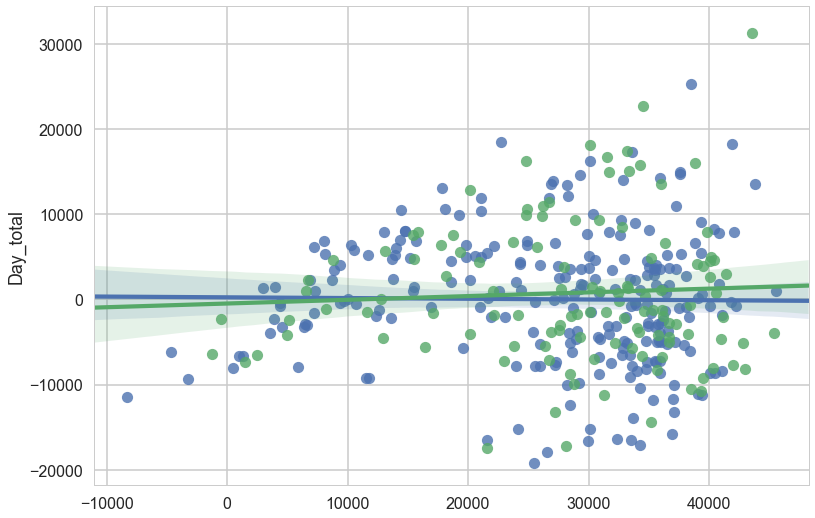

In [822]:
x = reg.predict(X_train)
y = reg.predict(X_train)-y_train

x1 = reg.predict(X_test)
y1 = reg.predict(X_test)-y_test

sns.regplot(x, y)
sns.regplot(x1,y1);


Histogram:

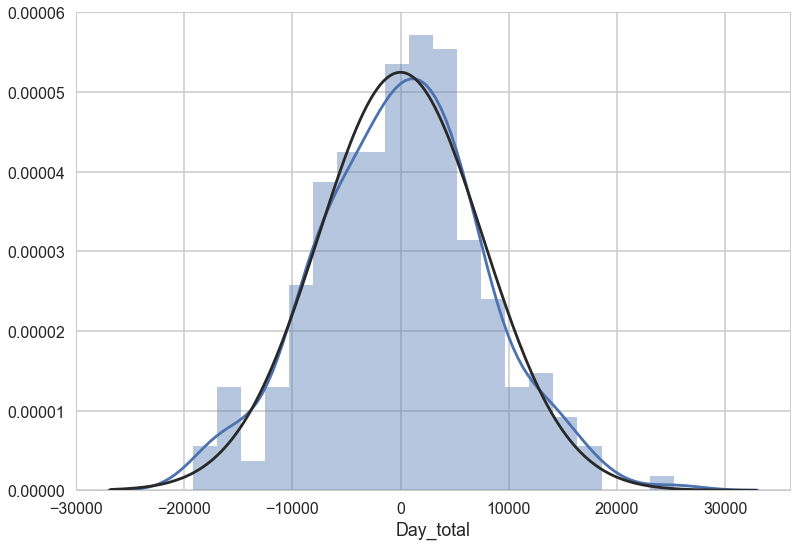

In [823]:
residuals = reg.predict(X_train)-y_train
sns.distplot(residuals, bins = 20,fit=stats.norm);


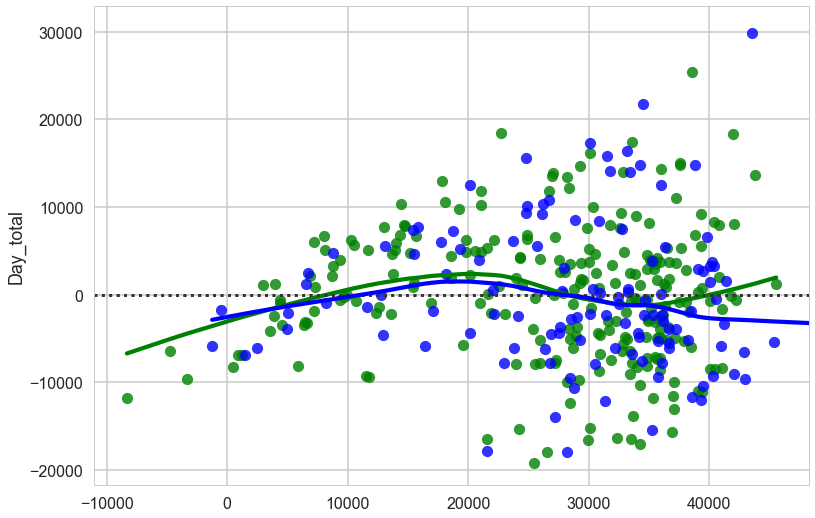

In [824]:
sns.residplot(x, y, lowess=True, color="g")
sns.residplot(x1, y1, lowess=True, color="b")

While the above model appear to have fairly normal and non-heteroskedastic residuals, the fit is not that awesome. I'm going to see if I can get better fits by introducing nonlinear terms and interactions. 
Since it is fairly slow and tedious to look through all these models, I made a function to check different models and runthrough a loop to check different polynomial degrees and find the model witht he best test score on the same dataset. This finds:  
1) The model train score, test score, and mse value for each polynomial degree  
2) The number of features in each model  
3) How many of the coefficients are effectively zero in each model (i.e., which features would drop out of each model)  
4) The alpha values for the Lasso and ridge regression models

In [838]:
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, ElasticNetCV)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def regression_check(X, y, polynomial_degree, interaction):
    normalized_X = preprocessing.normalize(X)
    X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=3)
    estimators = [('OLS', LinearRegression()),
                  ('HuberRegressor', HuberRegressor()),
                  ('ElasticNetCV', ElasticNetCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])),
                  ('LassoCV',LassoCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])),
                  ('RidgeCV', RidgeCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0]))]

    name = PolynomialFeatures(polynomial_degree, interaction_only=interaction).fit(X_train)
    features = name.get_feature_names(X.columns)

    df_coeff = pd.DataFrame()
    df_coeff['Feature_Names'] = features
    Error_metrics = dict()
    
    for name, estimator in estimators:
            dict_name = name + "_" + str(polynomial_degree)
            values_list = []
            model = make_pipeline(PolynomialFeatures(polynomial_degree, interaction_only=interaction), estimator)
            model.fit(X_train, y_train)
            mse = mean_squared_error(model.predict(X_test), y_test)
            try:
                estimator.alpha_
            except AttributeError:
                alpha_val = "-"
            else:
                alpha_val = estimator.alpha_
            values_list = [model.score(X_train,y_train),  model.score(X_test,y_test), mse, polynomial_degree, alpha_val, estimator]
            if dict_name not in Error_metrics.keys():
                Error_metrics[dict_name] = values_list
            y_plot = model.predict(X_test)
            #sns.regplot(x=y_test, y=y_plot)
            df_coeff[name] = estimator.coef_
    return df_coeff, Error_metrics
    
 

First, try dropping the 'temp_avg' variable as was recommended by the VIF check:

In [841]:
X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'Precip_cat', u'temp avg'], axis =1)
y = all_data['Day_total']
df_compiled = pd.DataFrame(columns = ["Train_Score", "Test_Score", "MSE", 'polynomial_degree', "alpha", 'estimator'])


for polynomial_degree in range(0,8):
    print("Degree:", polynomial_degree)
    df_coeff, Error_metrics = regression_check(X, y, polynomial_degree, False)
    headings = Error_metrics.keys()
    df_compiled = pd.concat([df_compiled,pd.DataFrame(Error_metrics.values(), index=headings, columns = ["Train_Score", "Test_Score", "MSE",'polynomial_degree', "alpha",'estimator'])])
    df_coeff[(df_coeff <0.000000001)] = np.nan
    print("# of features = ", df_coeff.shape[0])
    print(df_coeff.isnull().sum())

df_compiled = df_compiled.sort_values(by = "Test_Score", axis = 0, ascending = False)
best_degree = df_compiled.iloc[0]['polynomial_degree']
best_alpha = df_compiled.iloc[0]['alpha']
best_model = df_compiled.iloc[0]['estimator']

#degree

Degree: 0
# of features =  1
Feature_Names     0
OLS               1
HuberRegressor    0
ElasticNetCV      1
LassoCV           1
RidgeCV           1
dtype: int64
Degree: 1
# of features =  5
Feature_Names     0
OLS               2
HuberRegressor    3
ElasticNetCV      2
LassoCV           2
RidgeCV           2
dtype: int64
Degree: 2
# of features =  15
Feature_Names      0
OLS                8
HuberRegressor     8
ElasticNetCV       8
LassoCV           13
RidgeCV            8
dtype: int64
Degree: 3
# of features =  35
Feature_Names      0
OLS               17
HuberRegressor    24
ElasticNetCV      17
LassoCV           32
RidgeCV           18
dtype: int64
Degree: 4
# of features =  70
Feature_Names      0
OLS               33
HuberRegressor    45
ElasticNetCV      31
LassoCV           67
RidgeCV           39
dtype: int64
Degree: 5
# of features =  126
Feature_Names       0
OLS                62
HuberRegressor     71
ElasticNetCV       46
LassoCV           121
RidgeCV            70
dtype:

In [842]:
df_compiled

Train_Score    Test_Score           MSE  polynomial_degree  \
RidgeCV_4            0.750304  7.148536e-01  5.174030e+07                4.0   
RidgeCV_5            0.757219  7.131793e-01  5.204411e+07                5.0   
RidgeCV_6            0.761579  7.100356e-01  5.261455e+07                6.0   
RidgeCV_3            0.748684  7.076571e-01  5.304613e+07                3.0   
RidgeCV_7            0.764611  7.066334e-01  5.323188e+07                7.0   
ElasticNetCV_7       0.685685  6.988988e-01  5.463533e+07                7.0   
OLS_1                0.653841  6.957034e-01  5.521514e+07                1.0   
RidgeCV_2            0.726866  6.951822e-01  5.530972e+07                2.0   
OLS_2                0.726866  6.951738e-01  5.531124e+07                2.0   
ElasticNetCV_5       0.678451  6.943337e-01  5.546369e+07                5.0   
ElasticNetCV_4       0.674062  6.912098e-01  5.603052e+07                4.0   
LassoCV_1            0.652539  6.901947e-01  5.621472e+07                1.0   
RidgeCV_1            0.651609  6.879929e-01  5.661423e+07                1.0   
ElasticNetCV_3       0.669140  6.873149e-01  5.673725e+07                3.0   
ElasticNetCV_2       0.668437  6.869390e-01  5.680546e+07                2.0   
ElasticNetCV_1       0.650770  6.864601e-01  5.689237e+07                1.0   
ElasticNetCV_6       0.778023  6.847961e-01  5.719430e+07                6.0   
LassoCV_3            0.663651  6.846144e-01  5.722726e+07                3.0   
LassoCV_4            0.664172  6.844090e-01  5.726454e+07                4.0   
LassoCV_2            0.663263  6.841486e-01  5.731178e+07                2.0   
LassoCV_5            0.665851  6.839502e-01  5.734778e+07                5.0   
LassoCV_7            0.668256  6.836207e-01  5.740758e+07                7.0   
LassoCV_6            0.667501  6.833215e-01  5.746187e+07                6.0   
HuberRegressor_7     0.650425  6.599738e-01  6.169835e+07                7.0   
HuberRegressor_6     0.648001  6.583421e-01  6.199442e+07                6.0   
HuberRegressor_5     0.645156  6.562063e-01  6.238197e+07                5.0   
HuberRegressor_4     0.641841  6.537503e-01  6.282761e+07                4.0   
HuberRegressor_3     0.637251  6.514187e-01  6.325067e+07                3.0   
HuberRegressor_2     0.627087  6.478058e-01  6.390624e+07                2.0   
OLS_3                0.754568  6.363490e-01  6.598511e+07                3.0   
HuberRegressor_1     0.585308  6.241629e-01  6.819630e+07                1.0   
OLS_4                0.765613  2.283441e-01  1.400183e+08                4.0   
OLS_0                0.000000 -1.045155e-02  1.833482e+08                0.0   
ElasticNetCV_0       0.000000 -1.045155e-02  1.833482e+08                0.0   
LassoCV_0            0.000000 -1.045155e-02  1.833482e+08                0.0   
RidgeCV_0            0.000000 -1.045155e-02  1.833482e+08                0.0   
HuberRegressor_0    -0.002650 -2.356803e-02  1.857282e+08                0.0   
OLS_5                0.798405 -1.588874e+03  2.884855e+11                5.0   
OLS_6                0.890889 -4.750131e+06  8.619198e+14                6.0   
OLS_7                0.940485 -8.095932e+10  1.469021e+19                7.0   

                   alpha                                          estimator  
RidgeCV_4         0.0005  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
RidgeCV_5         0.0005  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
RidgeCV_6         0.0005  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
RidgeCV_3         0.0001  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
RidgeCV_7         0.0005  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_7     0.001  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
OLS_1                  -  LinearRegression(copy_X=True, fit_intercept=Tr...  
RidgeCV_2          1e-07  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
OLS_2                  -  LinearReg

Train: 0.73323263646
Test: 0.71490355098
alpha =: 0.0005
Coefficients are:                             Feature_Names   Coefficients
0                                       1       0.000000
1                                avg wind   58901.172148
2                              Precip(in)  -59546.493793
3                                   month  -83025.208563
4                             day_of_week    7072.321920
5                              avg wind^2 -128544.822735
6                     avg wind Precip(in)  -27108.529095
7                          avg wind month   58362.014157
8                    avg wind day_of_week   69374.474059
9                            Precip(in)^2  331200.919523
10                       Precip(in) month  -93556.358666
11                 Precip(in) day_of_week   22620.219006
12                                month^2  -37051.821095
13                      month day_of_week  -27027.948869
14                          day_of_week^2 -165604.275692
15           

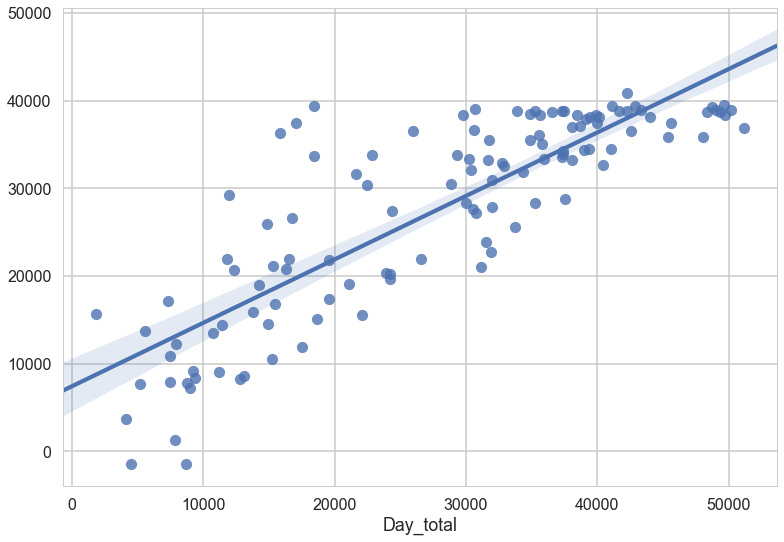

In [843]:
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)

#Get feature names
name = PolynomialFeatures(degree = int(best_degree), interaction_only=False).fit(X_train)
features = name.get_feature_names(X.columns)

reg = RidgeCV(alphas=[best_alpha])
model = make_pipeline(PolynomialFeatures(degree = int(best_degree),interaction_only=False ), reg)
fit = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_test, y=y_pred)

# Print out the R^2 for the model against the test dataset
print("Train:", model.score(X_train,y_train))
print("Test:", model.score(X_test,y_test))

df_model_coeff = pd.DataFrame()
df_model_coeff['Feature_Names'] = features
df_model_coeff["Coefficients"] = reg.coef_
print("alpha =:", reg.alpha_)
print("Coefficients are:", df_model_coeff)



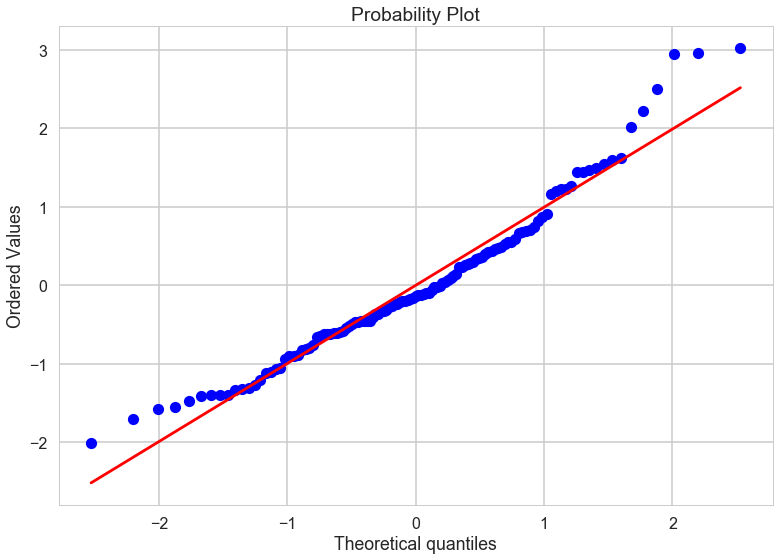

In [844]:
residuals_te = y_pred-y_test
residuals_tr = model.predict(X_train)-y_train

#probplot:
obs = residuals_te
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm",plot=pylab)
pylab.show()

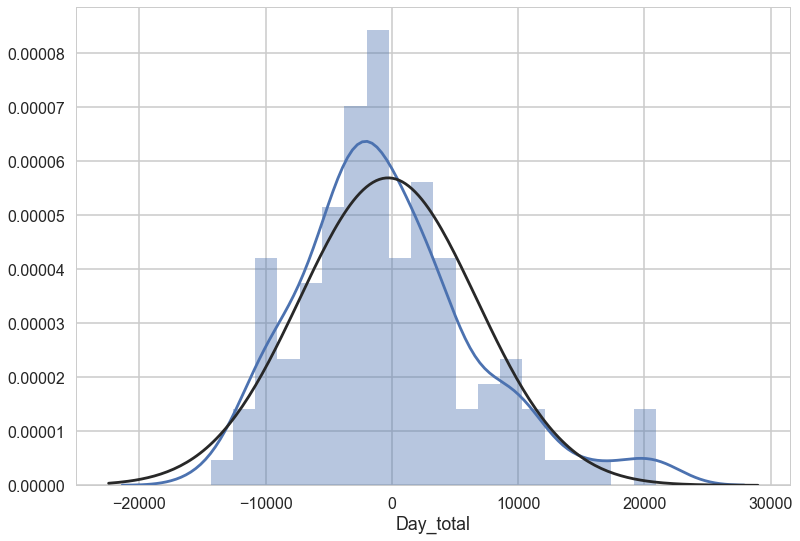

In [845]:
#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);

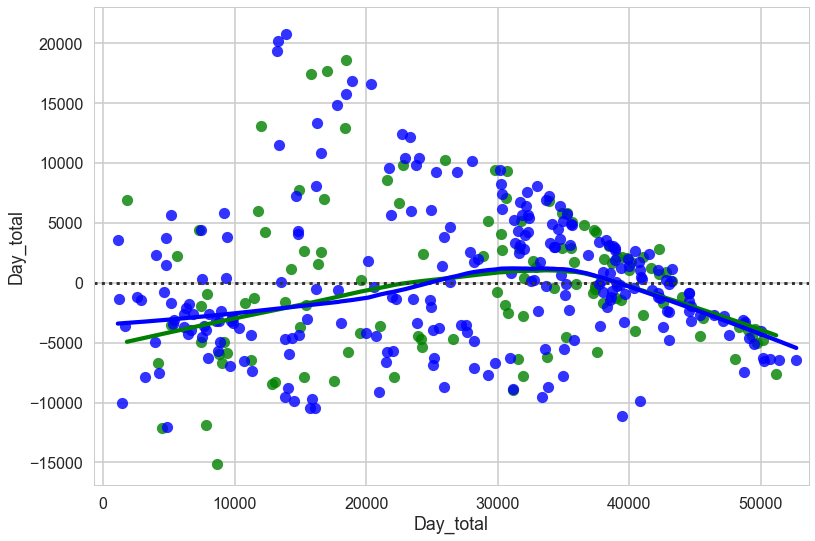

In [846]:
#residuals trend
sns.residplot(y_test, residuals_te, lowess=True, color="g")
sns.residplot(y_train, residuals_tr, lowess=True, color="b")


Feature = avg wind


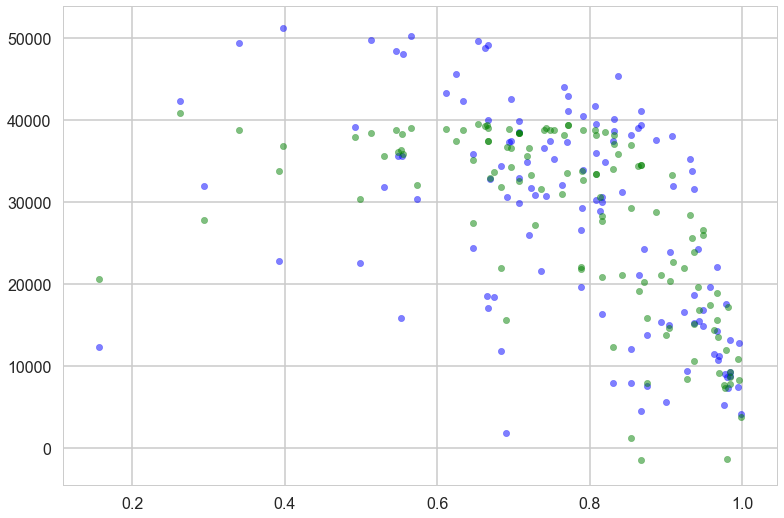

Feature = Precip(in)


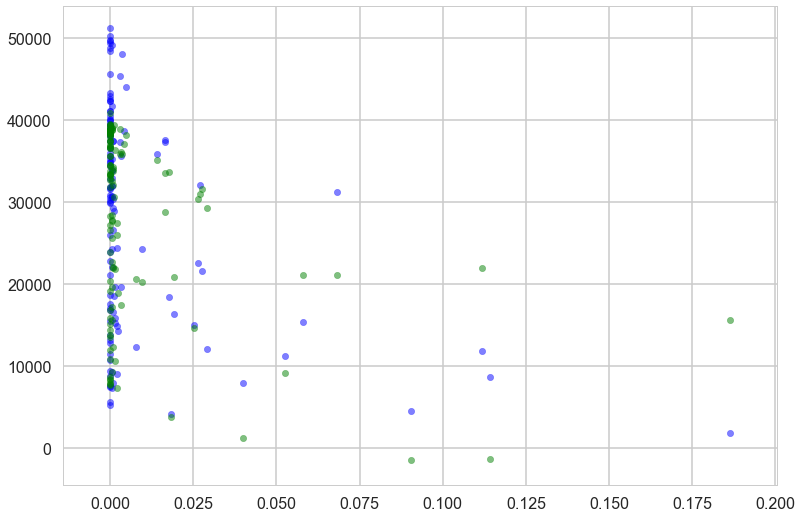

Feature = month


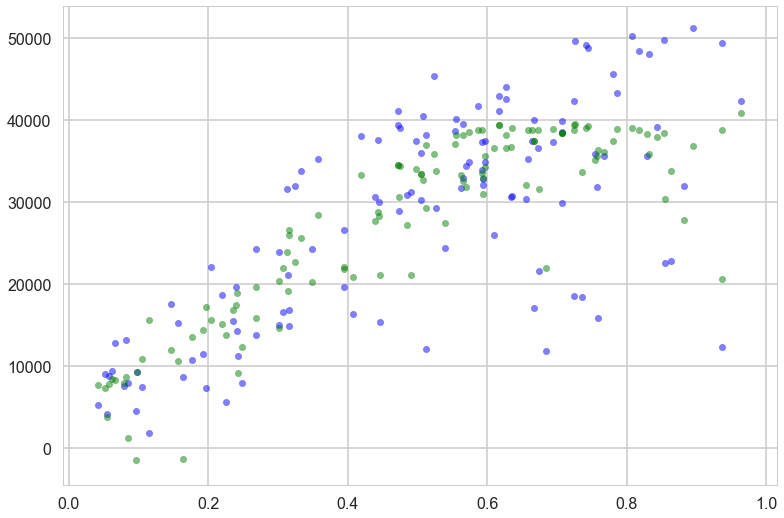

Feature = day_of_week


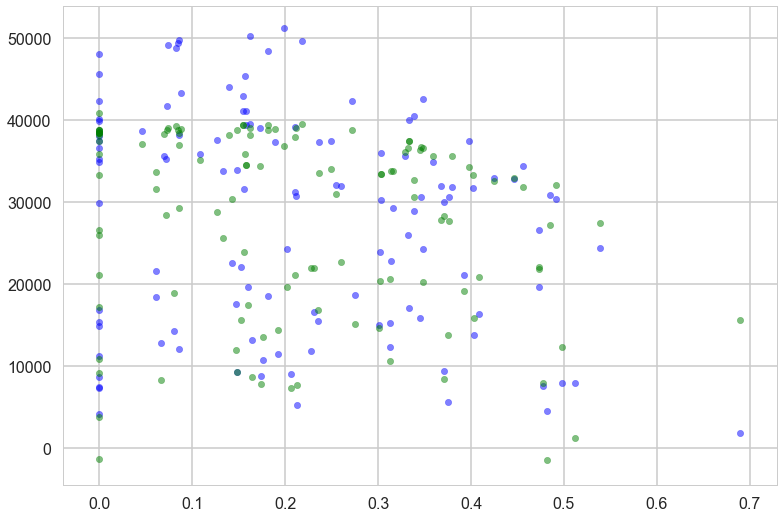

In [847]:
for var in range(0, X.shape[1]):
    print("Feature =", X.columns[var])
    plt.figure()
    plt.scatter(X_test[:,var], y_test, c="b", s=40, alpha = 0.5)
    plt.scatter(X_test[:,var], y_pred, c="g", s=40, alpha = 0.5)
    plt.show()

Then try leaving in the 'temp_avg':

In [848]:
X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'Precip_cat'], axis =1)
y = all_data['Day_total']
df_compiled = pd.DataFrame(columns = ["Train_Score", "Test_Score", "MSE", 'polynomial_degree', "alpha", 'estimator'])


for polynomial_degree in range(0,8):
    print("Degree:", polynomial_degree)
    df_coeff, Error_metrics = regression_check(X, y, polynomial_degree, False)
    headings = Error_metrics.keys()
    df_compiled = pd.concat([df_compiled,pd.DataFrame(Error_metrics.values(), index=headings, columns = ["Train_Score", "Test_Score", "MSE",'polynomial_degree', "alpha",'estimator'])])
    df_coeff[(df_coeff <0.000000001)] = np.nan
    print("# of features = ", df_coeff.shape[0])
    print(df_coeff.isnull().sum())

df_compiled = df_compiled.sort_values(by = "Test_Score", axis = 0, ascending = False)
best_degree = df_compiled.iloc[0]['polynomial_degree']
best_alpha = df_compiled.iloc[0]['alpha']
best_model = df_compiled.iloc[0]['estimator']

#degree

Degree: 0
# of features =  1
Feature_Names     0
OLS               1
HuberRegressor    0
ElasticNetCV      1
LassoCV           1
RidgeCV           1
dtype: int64
Degree: 1
# of features =  6
Feature_Names     0
OLS               5
HuberRegressor    3
ElasticNetCV      5
LassoCV           5
RidgeCV           5
dtype: int64
Degree: 2
# of features =  21
Feature_Names      0
OLS               12
HuberRegressor    17
ElasticNetCV       8
LassoCV            8
RidgeCV           10
dtype: int64
Degree: 3
# of features =  56
Feature_Names      0
OLS               37
HuberRegressor    48
ElasticNetCV      25
LassoCV           36
RidgeCV           30
dtype: int64
Degree: 4
# of features =  126
Feature_Names       0
OLS                40
HuberRegressor    104
ElasticNetCV       48
LassoCV            98
RidgeCV            58
dtype: int64
Degree: 5
# of features =  252
Feature_Names       0
OLS               120
HuberRegressor    212
ElasticNetCV       76
LassoCV           212
RidgeCV           101

In [849]:
df_compiled

Train_Score    Test_Score           MSE  polynomial_degree  \
LassoCV_7            0.829762  7.926950e-01  3.761585e+07                7.0   
LassoCV_6            0.829079  7.919884e-01  3.774407e+07                6.0   
LassoCV_5            0.828560  7.913534e-01  3.785930e+07                5.0   
ElasticNetCV_7       0.828145  7.907486e-01  3.796903e+07                7.0   
LassoCV_4            0.828523  7.901290e-01  3.808146e+07                4.0   
ElasticNetCV_6       0.825025  7.895538e-01  3.818584e+07                6.0   
ElasticNetCV_5       0.821742  7.874131e-01  3.857426e+07                5.0   
ElasticNetCV_4       0.818044  7.839328e-01  3.920576e+07                4.0   
RidgeCV_3            0.822494  7.831701e-01  3.934417e+07                3.0   
RidgeCV_4            0.808168  7.761377e-01  4.062021e+07                4.0   
LassoCV_3            0.823970  7.760771e-01  4.063120e+07                3.0   
RidgeCV_5            0.805693  7.758526e-01  4.067193e+07                5.0   
ElasticNetCV_3       0.809154  7.710130e-01  4.155008e+07                3.0   
RidgeCV_7            0.793509  7.649817e-01  4.264449e+07                7.0   
RidgeCV_6            0.790136  7.593527e-01  4.366588e+07                6.0   
LassoCV_2            0.789564  7.415653e-01  4.689342e+07                2.0   
ElasticNetCV_2       0.773343  7.391122e-01  4.733855e+07                2.0   
RidgeCV_2            0.796007  7.182442e-01  5.112508e+07                2.0   
OLS_2                0.811206  7.037733e-01  5.375086e+07                2.0   
OLS_1                0.671629  6.482556e-01  6.382463e+07                1.0   
LassoCV_1            0.671477  6.476925e-01  6.392680e+07                1.0   
RidgeCV_1            0.670973  6.461161e-01  6.421285e+07                1.0   
ElasticNetCV_1       0.670691  6.456345e-01  6.430024e+07                1.0   
HuberRegressor_7     0.634141  6.222879e-01  6.853652e+07                7.0   
HuberRegressor_6     0.626319  6.173217e-01  6.943764e+07                6.0   
HuberRegressor_5     0.617465  6.114199e-01  7.050854e+07                5.0   
HuberRegressor_4     0.607052  6.039507e-01  7.186384e+07                4.0   
HuberRegressor_3     0.592530  5.922866e-01  7.398031e+07                3.0   
HuberRegressor_2     0.564548  5.659647e-01  7.875646e+07                2.0   
HuberRegressor_1     0.506506  5.023703e-01  9.029578e+07                1.0   
OLS_0                0.000000 -1.045155e-02  1.833482e+08                0.0   
ElasticNetCV_0       0.000000 -1.045155e-02  1.833482e+08                0.0   
LassoCV_0            0.000000 -1.045155e-02  1.833482e+08                0.0   
RidgeCV_0            0.000000 -1.045155e-02  1.833482e+08                0.0   
HuberRegressor_0    -0.002650 -2.356803e-02  1.857282e+08                0.0   
OLS_3                0.764957 -3.010127e-01  2.360710e+08                3.0   
OLS_4                0.256864 -1.182572e+03  2.147613e+11                4.0   
OLS_5                0.986725 -8.794082e+08  1.595701e+17                5.0   
OLS_7                1.000000 -4.199772e+10  7.620560e+18                7.0   
OLS_6                0.999226 -8.940045e+13  1.622187e+22                6.0   

                   alpha                                          estimator  
LassoCV_7           0.05  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_6           0.05  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_5           0.05  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_7     1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
LassoCV_4           0.05  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_6     1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
ElasticNetCV_5     1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
ElasticNetCV_4     1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
RidgeCV_3          5e-06  RidgeCV(a

In [858]:
df_compiled.iloc[0]['estimator']

LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0],
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

Train: 0.829761904179
Test: 0.792695030228
alpha =: 0.05
Coefficients are:                           Feature_Names  Coefficients
0                                     1  0.000000e+00
1                              temp avg  9.208543e+04
2                              avg wind  1.856617e+03
3                            Precip(in) -2.855673e+05
4                                 month  1.120173e+05
5                           day_of_week  8.261673e+04
6                            temp avg^2  1.602327e+04
7                     temp avg avg wind  1.510708e+04
8                   temp avg Precip(in) -0.000000e+00
9                        temp avg month  2.275509e+04
10                 temp avg day_of_week  1.263249e+04
11                           avg wind^2 -7.741717e+03
12                  avg wind Precip(in) -0.000000e+00
13                       avg wind month -0.000000e+00
14                 avg wind day_of_week -0.000000e+00
15                         Precip(in)^2  1.884498e+07
16     

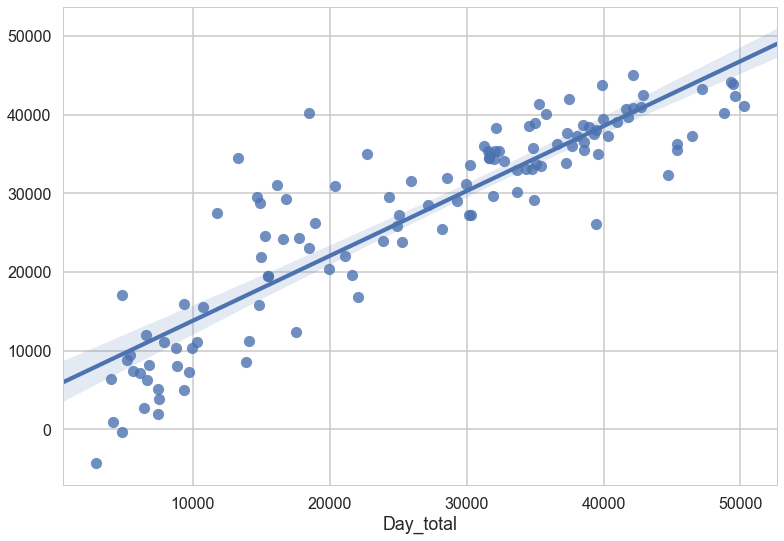

In [859]:
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=3)

#Get feature names
name = PolynomialFeatures(degree = int(best_degree), interaction_only=False).fit(X_train)
features = name.get_feature_names(X.columns)

reg = LassoCV(alphas=[best_alpha])
model = make_pipeline(PolynomialFeatures(degree = int(best_degree),interaction_only=False ), reg)
fit = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_test, y=y_pred)

# Print out the R^2 for the model against the test dataset
print("Train:", model.score(X_train,y_train))
print("Test:", model.score(X_test,y_test))

df_model_coeff = pd.DataFrame()
df_model_coeff['Feature_Names'] = features
df_model_coeff["Coefficients"] = reg.coef_
print("alpha =:", reg.alpha_)
print("Coefficients are:", df_model_coeff)


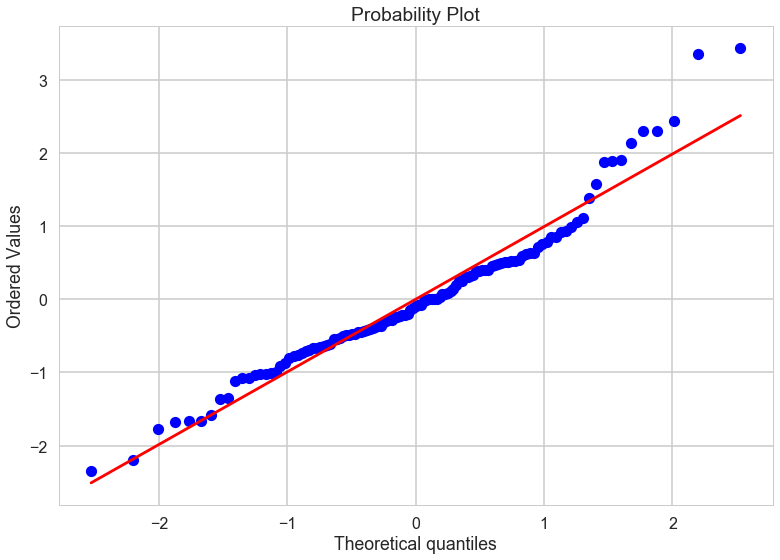

Feature = temp avg


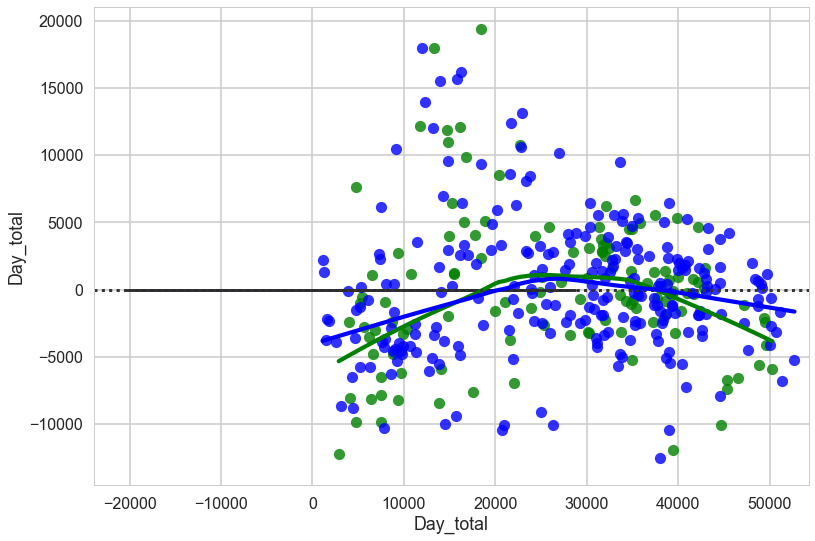

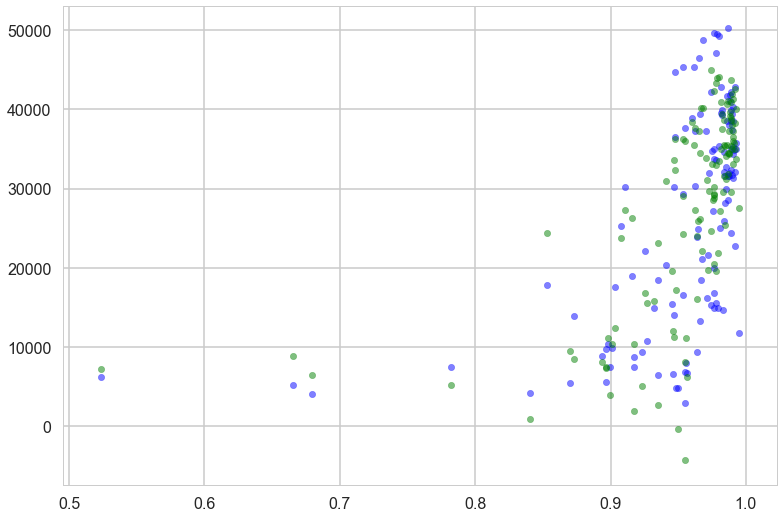

Feature = avg wind


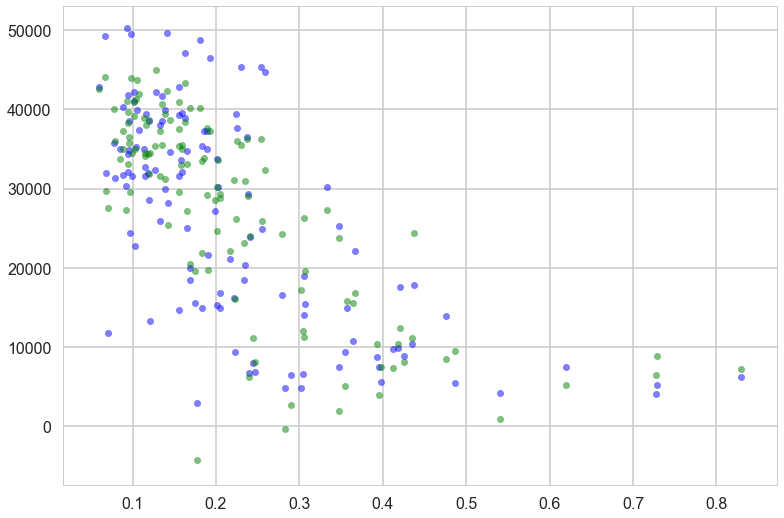

Feature = Precip(in)


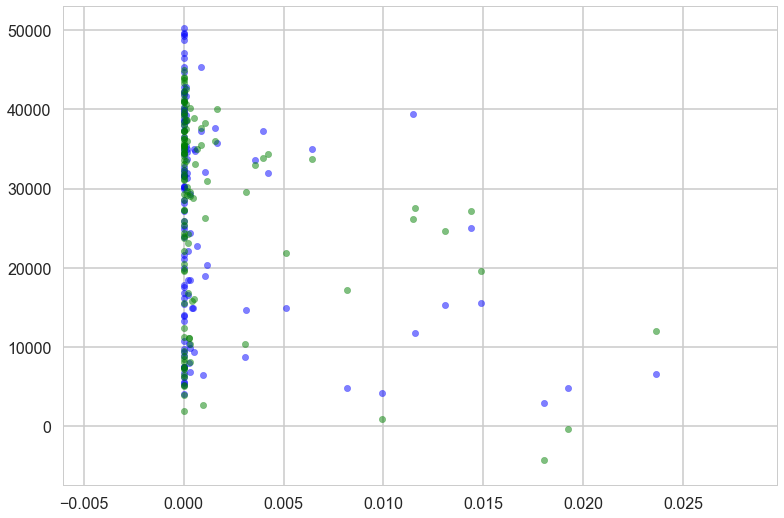

Feature = month


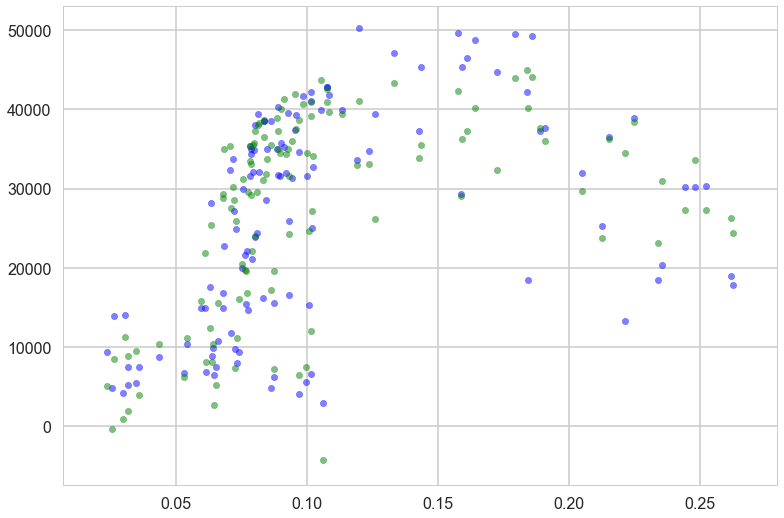

Feature = day_of_week


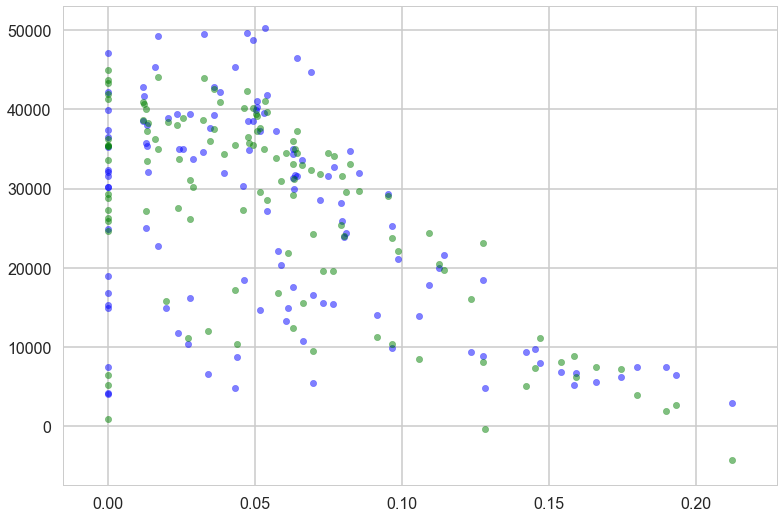

In [860]:
residuals_te = y_pred-y_test
residuals_tr = model.predict(X_train)-y_train

#probplot:
obs = residuals_te
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm",plot=pylab)
pylab.show()


#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);


#residuals trend
sns.residplot(y_test, residuals_te, lowess=True, color="g")
sns.residplot(y_train, residuals_tr, lowess=True, color="b")

for var in range(0, X.shape[1]):
    print("Feature =", X.columns[var])
    plt.figure()
    plt.scatter(X_test[:,var], y_test, c="b", s=40, alpha = 0.5)
    plt.scatter(X_test[:,var], y_pred, c="g", s=40, alpha = 0.5)
    plt.show()

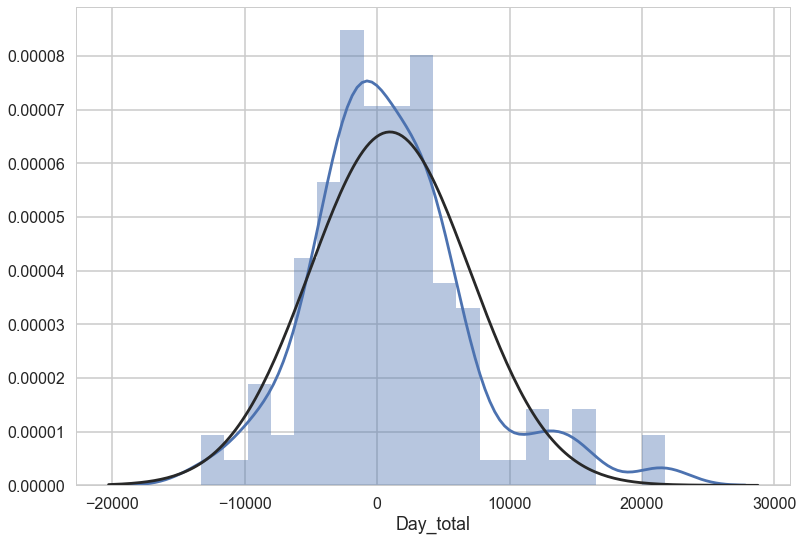

In [861]:
#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);

Then try the precipitation as a category rather than as a number (0 for no/trace precip, 1 for precip):

In [862]:
X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'Precip(in)'], axis =1)
y = all_data['Day_total']
df_compiled = pd.DataFrame(columns = ["Train_Score", "Test_Score", "MSE", 'polynomial_degree', "alpha", 'estimator'])


for polynomial_degree in range(0,8):
    print("Degree:", polynomial_degree)
    df_coeff, Error_metrics = regression_check(X, y, polynomial_degree, False)
    headings = Error_metrics.keys()
    df_compiled = pd.concat([df_compiled,pd.DataFrame(Error_metrics.values(), index=headings, columns = ["Train_Score", "Test_Score", "MSE",'polynomial_degree', "alpha",'estimator'])])
    df_coeff[(df_coeff <0.000000001)] = np.nan
    print("# of features = ", df_coeff.shape[0])
    print(df_coeff.isnull().sum())

df_compiled = df_compiled.sort_values(by = "Test_Score", axis = 0, ascending = False)
best_degree = df_compiled.iloc[0]['polynomial_degree']
best_alpha = df_compiled.iloc[0]['alpha']
best_model = df_compiled.iloc[0]['estimator']

#degree

Degree: 0
# of features =  1
Feature_Names     0
OLS               1
HuberRegressor    0
ElasticNetCV      1
LassoCV           1
RidgeCV           1
dtype: int64
Degree: 1
# of features =  6
Feature_Names     0
OLS               5
HuberRegressor    4
ElasticNetCV      5
LassoCV           5
RidgeCV           5
dtype: int64
Degree: 2
# of features =  21
Feature_Names      0
OLS               12
HuberRegressor    17
ElasticNetCV      10
LassoCV           10
RidgeCV            9
dtype: int64
Degree: 3
# of features =  56
Feature_Names      0
OLS               38
HuberRegressor    48
ElasticNetCV      24
LassoCV           35
RidgeCV           28
dtype: int64
Degree: 4
# of features =  126
Feature_Names       0
OLS                86
HuberRegressor    104
ElasticNetCV       51
LassoCV            98
RidgeCV            59
dtype: int64
Degree: 5
# of features =  252
Feature_Names       0
OLS               125
HuberRegressor    209
ElasticNetCV       89
LassoCV           210
RidgeCV           106

In [863]:
df_compiled

Train_Score    Test_Score           MSE  polynomial_degree  \
LassoCV_4            0.849919  8.153556e-01  3.350404e+07                4.0   
LassoCV_6            0.851357  8.152356e-01  3.352583e+07                6.0   
LassoCV_5            0.850596  8.147210e-01  3.361920e+07                5.0   
ElasticNetCV_5       0.851443  8.127189e-01  3.398247e+07                5.0   
ElasticNetCV_4       0.848538  8.089105e-01  3.467352e+07                4.0   
LassoCV_3            0.844787  8.070420e-01  3.501256e+07                3.0   
RidgeCV_3            0.847393  8.050743e-01  3.536960e+07                3.0   
LassoCV_7            0.843634  7.998314e-01  3.632094e+07                7.0   
RidgeCV_4            0.843764  7.994361e-01  3.639266e+07                4.0   
RidgeCV_5            0.842936  7.986494e-01  3.653542e+07                5.0   
ElasticNetCV_3       0.840950  7.965498e-01  3.691639e+07                3.0   
RidgeCV_7            0.836120  7.865718e-01  3.872693e+07                7.0   
RidgeCV_6            0.833767  7.806835e-01  3.979536e+07                6.0   
ElasticNetCV_7       0.832041  7.748090e-01  4.086130e+07                7.0   
ElasticNetCV_6       0.829779  7.697720e-01  4.177527e+07                6.0   
ElasticNetCV_2       0.813714  7.594376e-01  4.365047e+07                2.0   
LassoCV_2            0.813491  7.576006e-01  4.398379e+07                2.0   
RidgeCV_2            0.829844  7.544794e-01  4.455014e+07                2.0   
OLS_2                0.831182  7.387868e-01  4.739759e+07                2.0   
ElasticNetCV_1       0.708760  6.723953e-01  5.944443e+07                1.0   
RidgeCV_1            0.708890  6.717206e-01  5.956687e+07                1.0   
LassoCV_1            0.709087  6.705053e-01  5.978738e+07                1.0   
OLS_1                0.709174  6.680151e-01  6.023925e+07                1.0   
HuberRegressor_7     0.649071  6.407697e-01  6.518297e+07                7.0   
HuberRegressor_6     0.639602  6.339765e-01  6.641559e+07                6.0   
HuberRegressor_5     0.629072  6.260904e-01  6.784655e+07                5.0   
HuberRegressor_4     0.616832  6.164235e-01  6.960062e+07                4.0   
HuberRegressor_3     0.600339  6.023213e-01  7.215950e+07                3.0   
HuberRegressor_2     0.570231  5.733325e-01  7.741956e+07                2.0   
HuberRegressor_1     0.509619  5.065059e-01  8.954537e+07                1.0   
OLS_0                0.000000 -1.045155e-02  1.833482e+08                0.0   
ElasticNetCV_0       0.000000 -1.045155e-02  1.833482e+08                0.0   
LassoCV_0            0.000000 -1.045155e-02  1.833482e+08                0.0   
RidgeCV_0            0.000000 -1.045155e-02  1.833482e+08                0.0   
HuberRegressor_0    -0.002650 -2.356803e-02  1.857282e+08                0.0   
OLS_3               -0.064011 -3.770631e+00  8.656393e+08                3.0   
OLS_4                0.503227 -3.041873e+02  5.537677e+10                4.0   
OLS_6                0.989337 -6.858159e+10  1.244425e+19                6.0   
OLS_5                0.967254 -8.278524e+11  1.502153e+20                5.0   
OLS_7                0.999215 -6.746344e+13  1.224136e+22                7.0   

                   alpha                                          estimator  
LassoCV_4           0.05  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_6           0.05  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_5           0.05  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_5     1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
ElasticNetCV_4     1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
LassoCV_3           0.05  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
RidgeCV_3          1e-05  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_7            0.1  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
RidgeCV_4          5e-05  RidgeCV(a

Train: 0.846748615477
Test: 0.820158191274
alpha =: 0.05
Coefficients are:                              Feature_Names  Coefficients
0                                        1  0.000000e+00
1                                 temp avg  1.941431e+05
2                                 avg wind  9.342733e+03
3                               Precip_cat  0.000000e+00
4                                    month  2.071640e+05
5                              day_of_week  2.132321e+04
6                               temp avg^2  1.766761e+04
7                        temp avg avg wind  2.683818e+04
8                      temp avg Precip_cat  0.000000e+00
9                           temp avg month  2.712679e+04
10                    temp avg day_of_week -2.745483e+03
11                              avg wind^2 -1.193837e+03
12                     avg wind Precip_cat  1.966937e+05
13                          avg wind month -6.110741e+04
14                    avg wind day_of_week -1.680462e+04
15           

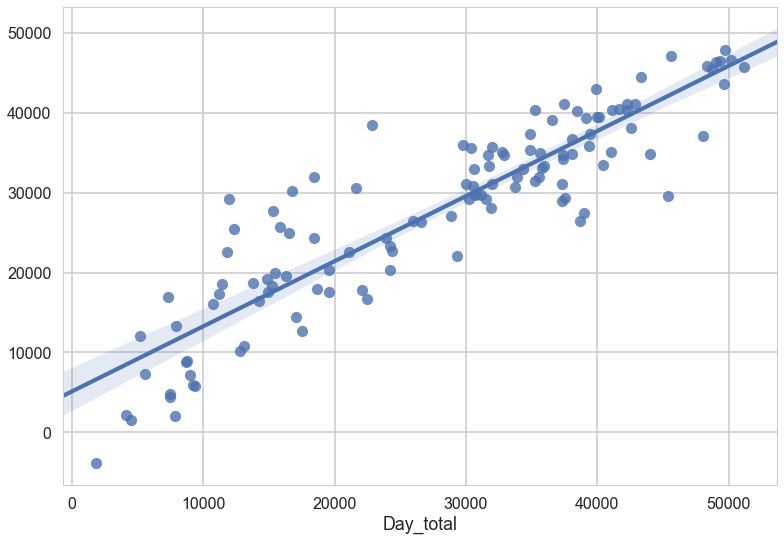

In [864]:
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)

#Get feature names
name = PolynomialFeatures(degree = int(best_degree), interaction_only=False).fit(X_train)
features = name.get_feature_names(X.columns)

reg = LassoCV(alphas=[best_alpha])
model = make_pipeline(PolynomialFeatures(degree = int(best_degree),interaction_only=False ), reg)
fit = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_test, y=y_pred)

# Print out the R^2 for the model against the test dataset
print("Train:", model.score(X_train,y_train))
print("Test:", model.score(X_test,y_test))

df_model_coeff = pd.DataFrame()
df_model_coeff['Feature_Names'] = features
df_model_coeff["Coefficients"] = reg.coef_
print("alpha =:", reg.alpha_)
print("Coefficients are:", df_model_coeff)


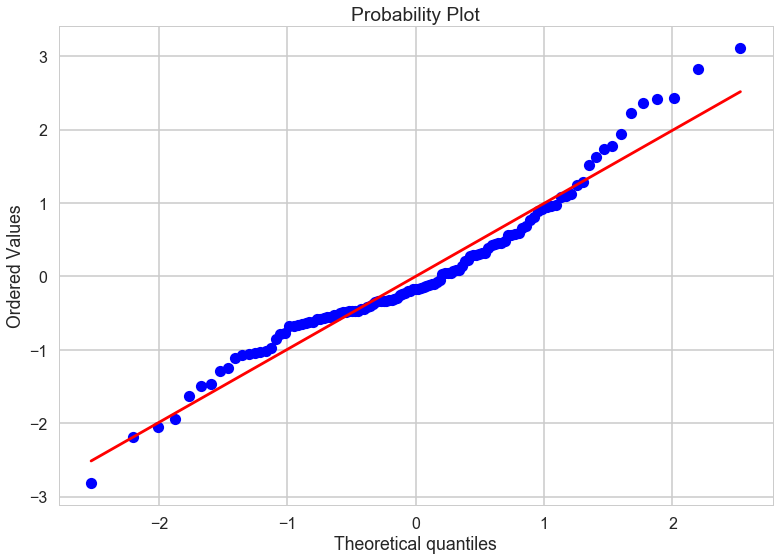

Feature = temp avg


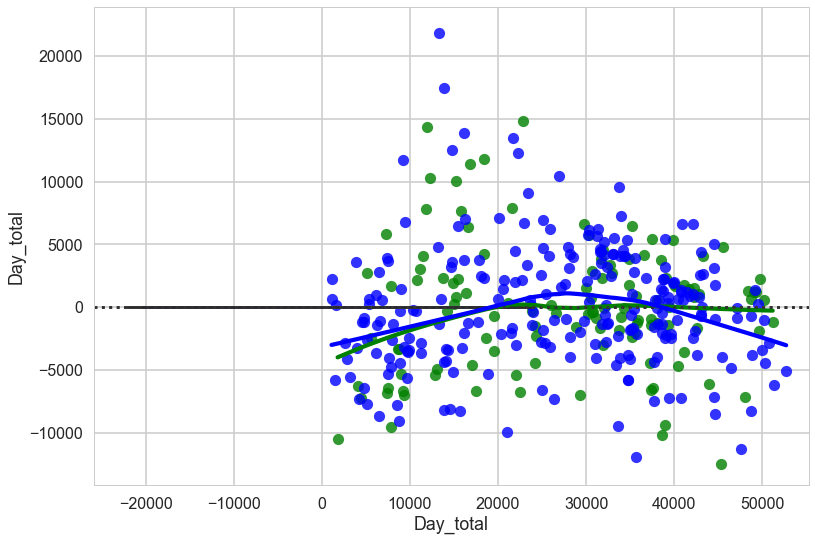

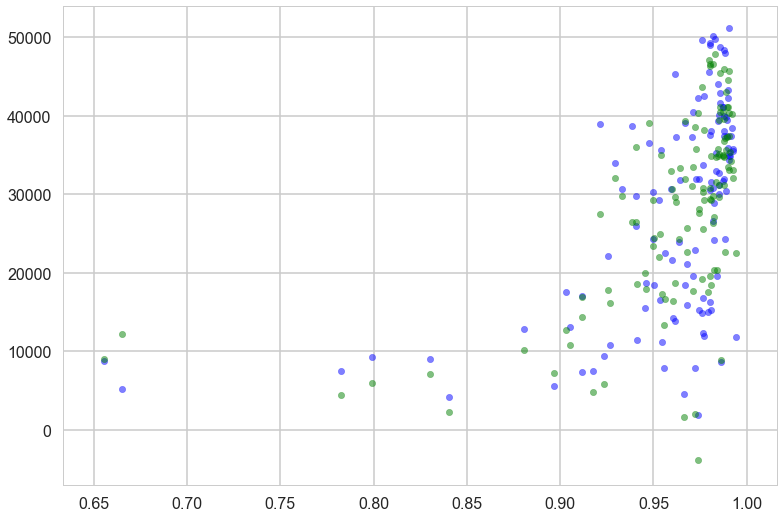

Feature = avg wind


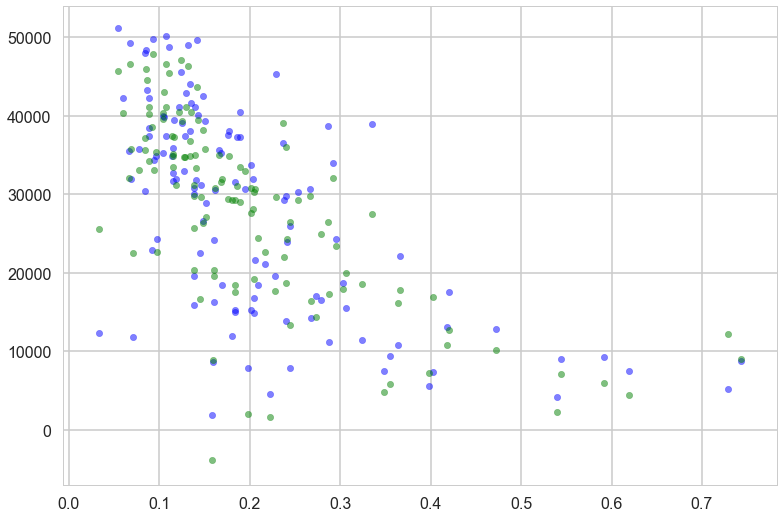

Feature = Precip_cat


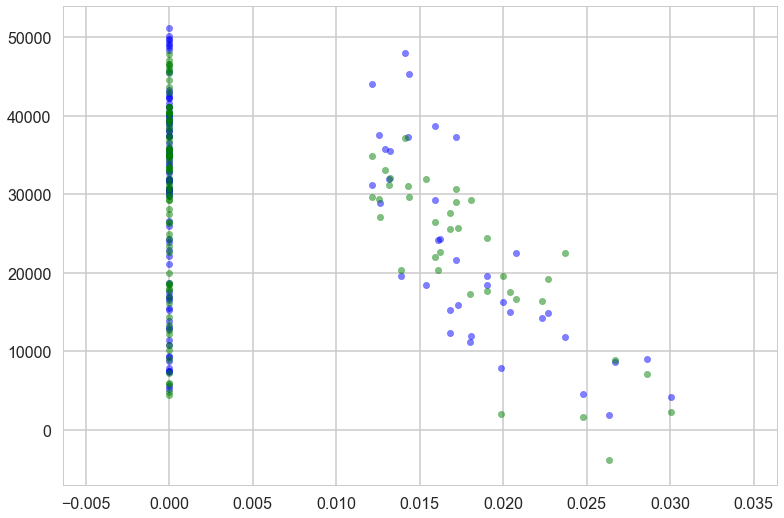

Feature = month


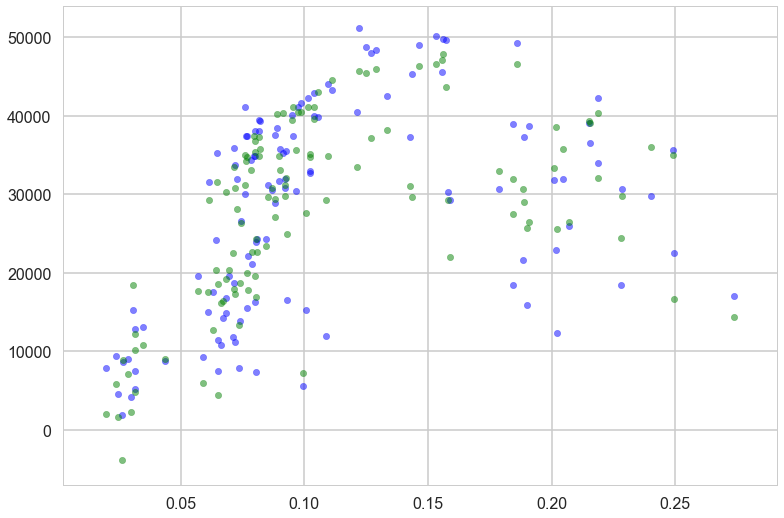

Feature = day_of_week


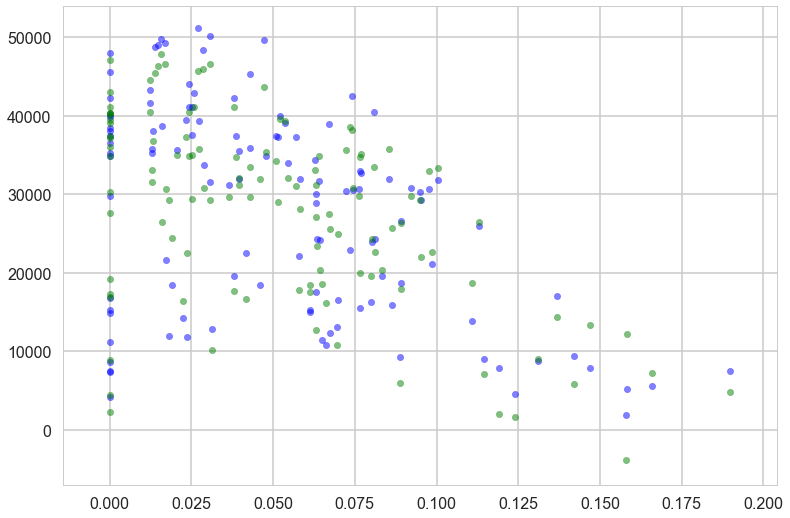

In [866]:
residuals_te = y_pred-y_test
residuals_tr = model.predict(X_train)-y_train

#probplot:
obs = residuals_te
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm",plot=pylab)
pylab.show()


#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);



#residuals trend
sns.residplot(y_test, residuals_te, lowess=True, color="g")
sns.residplot(y_train, residuals_tr, lowess=True, color="b")


for var in range(0, X.shape[1]):
    print("Feature =", X.columns[var])
    plt.figure()
    plt.scatter(X_test[:,var], y_test, c="b", s=40, alpha = 0.5)
    plt.scatter(X_test[:,var], y_pred, c="g", s=40, alpha = 0.5)
    plt.show()

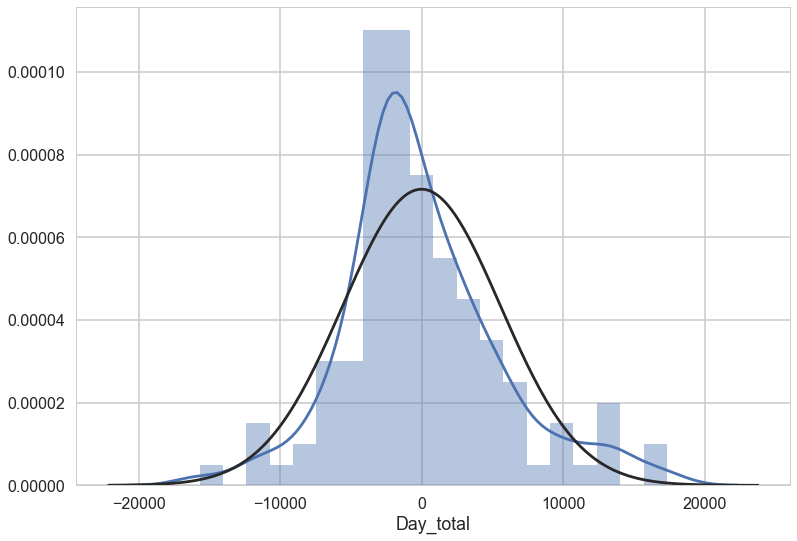

In [867]:
#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);


This model looks pretty good! I dont see heterskedacity in the residuals, they are normally distributed, and they are ~centered around zero.  
It is also clear from the table that there is no added benefit of adding polynomial terms to the LassoCV model after 4th degree. There is no corresponding model improvement. 

One last thing to try: fitting the summer/winter data separately.

Summer:

In [871]:
X = all_data[all_data['season'] == "summer"].drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'Precip(in)'], axis =1)
y = all_data[all_data['season'] == "summer"]['Day_total']
df_compiled = pd.DataFrame(columns = ["Train_Score", "Test_Score", "MSE", 'polynomial_degree', "alpha", 'estimator'])


for polynomial_degree in range(0,8):
    print("Degree:", polynomial_degree)
    df_coeff, Error_metrics = regression_check(X, y, polynomial_degree, False)
    headings = Error_metrics.keys()
    df_compiled = pd.concat([df_compiled,pd.DataFrame(Error_metrics.values(), index=headings, columns = ["Train_Score", "Test_Score", "MSE",'polynomial_degree', "alpha",'estimator'])])
    df_coeff[(df_coeff <0.000000001)] = np.nan
    print("# of features = ", df_coeff.shape[0])
    print(df_coeff.isnull().sum())

df_compiled = df_compiled.sort_values(by = "Test_Score", axis = 0, ascending = False)
best_degree = df_compiled.iloc[0]['polynomial_degree']
best_alpha = df_compiled.iloc[0]['alpha']
best_model = df_compiled.iloc[0]['estimator']

#degree

Degree: 0
# of features =  1
Feature_Names     0
OLS               1
HuberRegressor    0
ElasticNetCV      1
LassoCV           1
RidgeCV           1
dtype: int64
Degree: 1
# of features =  6
Feature_Names     0
OLS               3
HuberRegressor    3
ElasticNetCV      3
LassoCV           3
RidgeCV           3
dtype: int64
Degree: 2
# of features =  21
Feature_Names      0
OLS               13
HuberRegressor    14
ElasticNetCV       7
LassoCV            8
RidgeCV            7
dtype: int64
Degree: 3
# of features =  56
Feature_Names      0
OLS               40
HuberRegressor    43
ElasticNetCV      30
LassoCV           40
RidgeCV           26
dtype: int64
Degree: 4
# of features =  126
Feature_Names       0
OLS                75
HuberRegressor    106
ElasticNetCV       71
LassoCV           104
RidgeCV            66
dtype: int64
Degree: 5
# of features =  252
Feature_Names       0
OLS               115
HuberRegressor    221
ElasticNetCV      149
LassoCV           227
RidgeCV           130

In [872]:
df_compiled.head(10)

Train_Score  Test_Score           MSE  polynomial_degree  \
LassoCV_7          0.730375    0.631810  2.591579e+07                7.0   
LassoCV_6          0.730084    0.630593  2.600146e+07                6.0   
LassoCV_5          0.730523    0.628027  2.618206e+07                5.0   
ElasticNetCV_2     0.727209    0.626151  2.631408e+07                2.0   
LassoCV_4          0.732272    0.625664  2.634839e+07                4.0   
LassoCV_3          0.732472    0.624448  2.643393e+07                3.0   
ElasticNetCV_3     0.743321    0.622551  2.656745e+07                3.0   
ElasticNetCV_4     0.752168    0.616516  2.699227e+07                4.0   
ElasticNetCV_5     0.758383    0.610036  2.744840e+07                5.0   
RidgeCV_4          0.757883    0.606947  2.766580e+07                4.0   

                alpha                                          estimator  
LassoCV_7         0.1  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_6         0.1  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_5         0.1  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_2  1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
LassoCV_4         0.1  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_3         0.1  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_3  1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
ElasticNetCV_4  1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
ElasticNetCV_5  1e-07  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
RidgeCV_4       5e-06  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....

Train: 0.676495253845
Test: 0.713797190682
alpha =: 0.1
Coefficients are:                           Feature_Names  Coefficients
0                                     1  0.000000e+00
1                              temp avg  3.174277e+05
2                              avg wind -6.607213e+04
3                            Precip_cat -3.975087e+05
4                                 month -0.000000e+00
5                           day_of_week  8.503495e+04
6                            temp avg^2  5.145347e+04
7                     temp avg avg wind -0.000000e+00
8                   temp avg Precip_cat -0.000000e+00
9                        temp avg month  0.000000e+00
10                 temp avg day_of_week  1.885841e+03
11                           avg wind^2  0.000000e+00
12                  avg wind Precip_cat -1.236121e+06
13                       avg wind month  1.477005e+05
14                 avg wind day_of_week  1.843162e+05
15                         Precip_cat^2 -0.000000e+00
16      

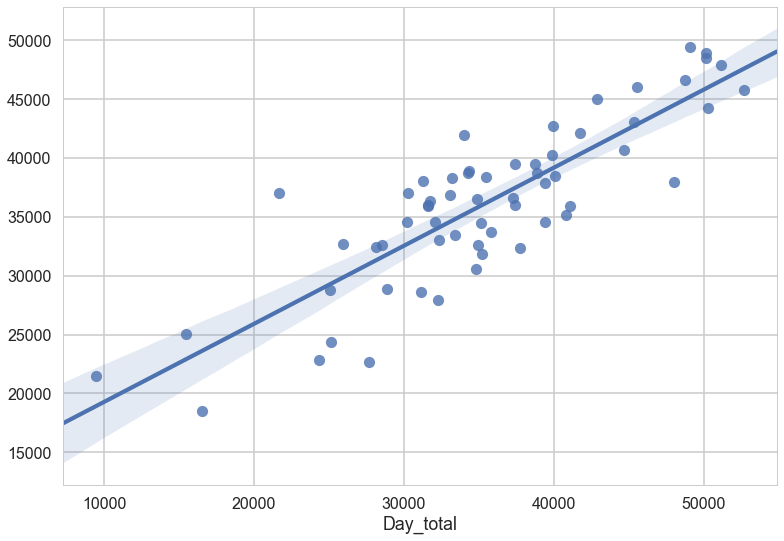

In [873]:
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)

#Get feature names
name = PolynomialFeatures(degree = int(best_degree), interaction_only=False).fit(X_train)
features = name.get_feature_names(X.columns)

reg = LassoCV(alphas=[best_alpha])
model = make_pipeline(PolynomialFeatures(degree = int(best_degree),interaction_only=False ), reg)
fit = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_test, y=y_pred)

# Print out the R^2 for the model against the test dataset
print("Train:", model.score(X_train,y_train))
print("Test:", model.score(X_test,y_test))

df_model_coeff = pd.DataFrame()
df_model_coeff['Feature_Names'] = features
df_model_coeff["Coefficients"] = reg.coef_
print("alpha =:", reg.alpha_)
print("Coefficients are:", df_model_coeff)


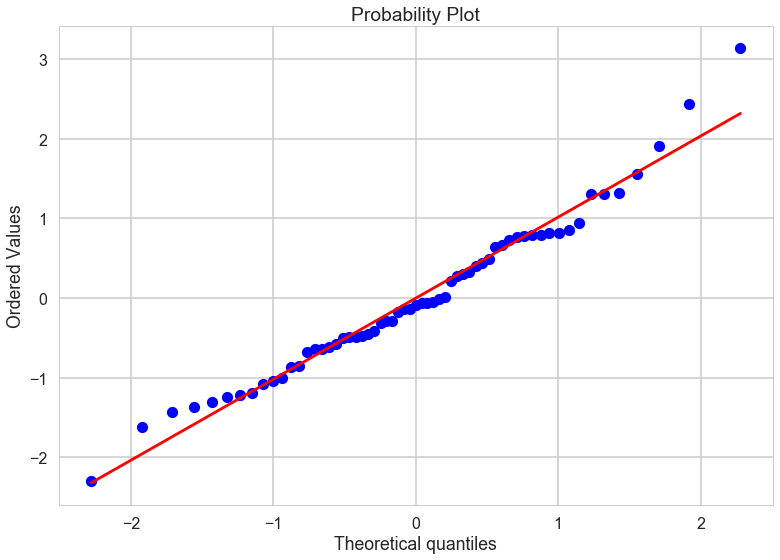

Feature = temp avg


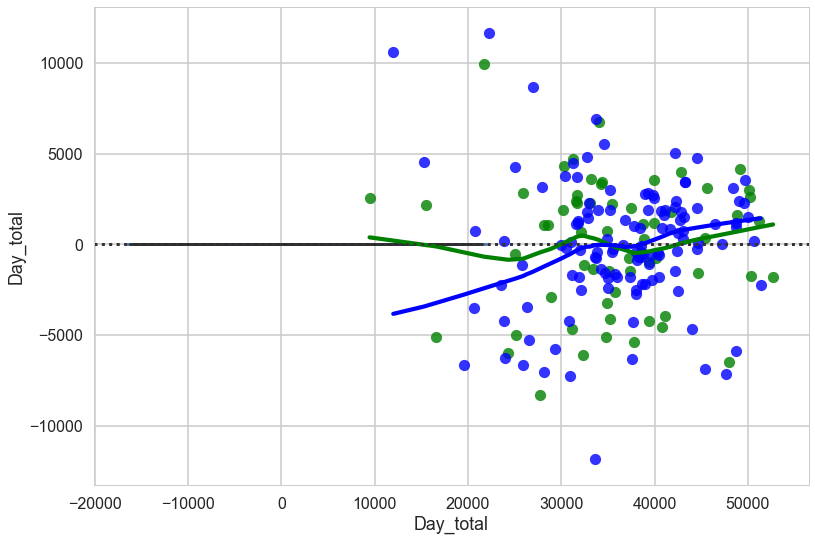

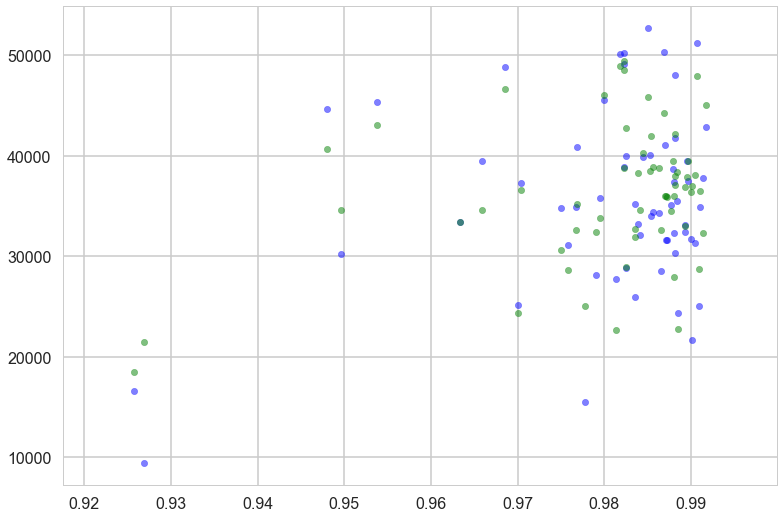

Feature = avg wind


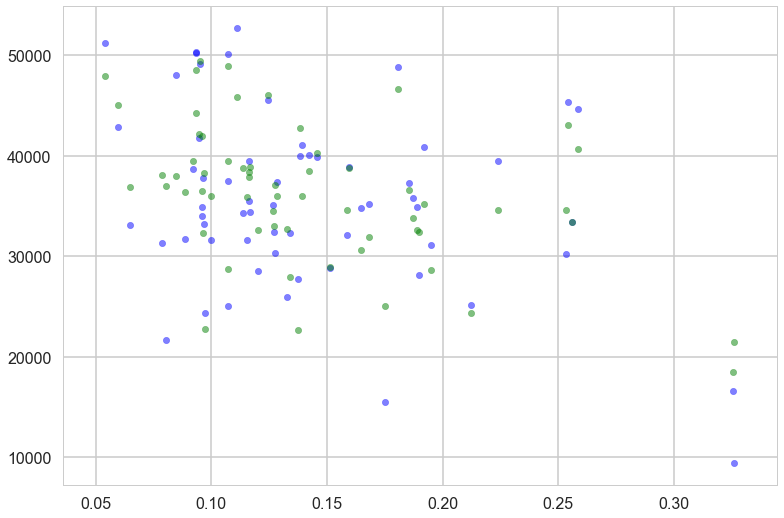

Feature = Precip_cat


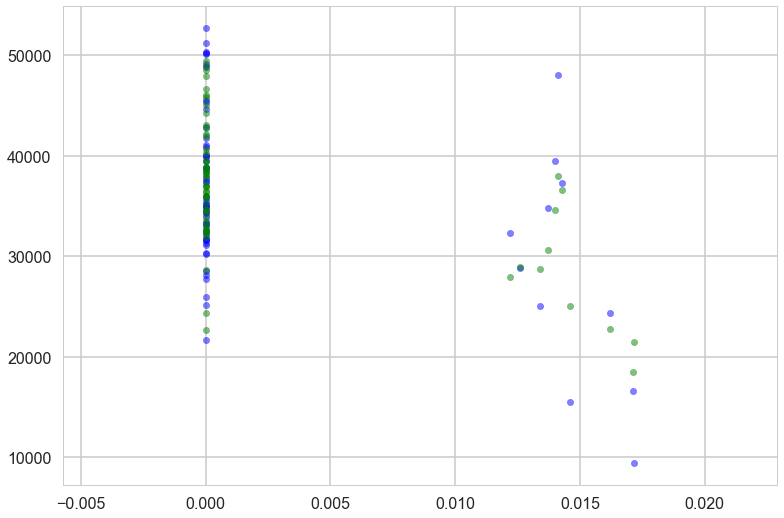

Feature = month


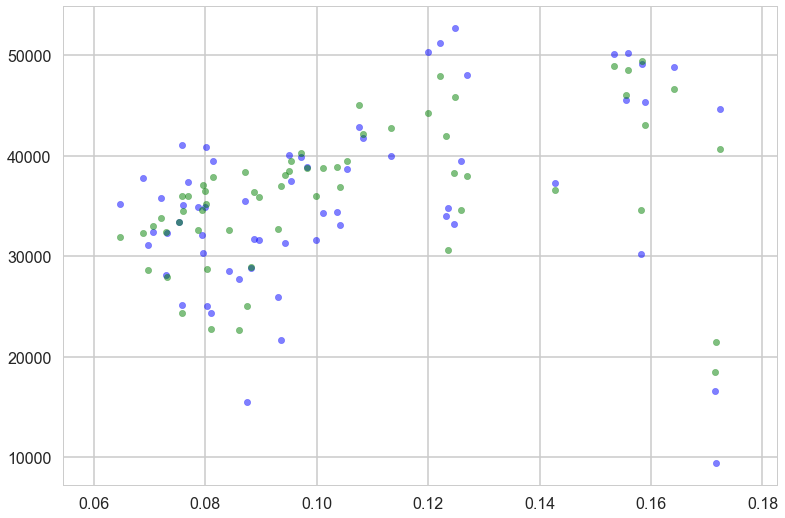

Feature = day_of_week


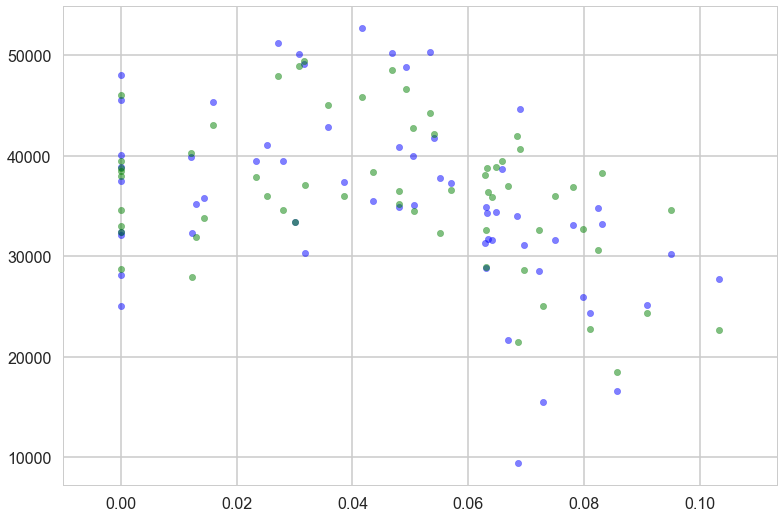

In [874]:
residuals_te = y_pred-y_test
residuals_tr = model.predict(X_train)-y_train

#probplot:
obs = residuals_te
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm",plot=pylab)
pylab.show()


#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);



#residuals trend
sns.residplot(y_test, residuals_te, lowess=True, color="g")
sns.residplot(y_train, residuals_tr, lowess=True, color="b")


for var in range(0, X.shape[1]):
    print("Feature =", X.columns[var])
    plt.figure()
    plt.scatter(X_test[:,var], y_test, c="b", s=40, alpha = 0.5)
    plt.scatter(X_test[:,var], y_pred, c="g", s=40, alpha = 0.5)
    plt.show()

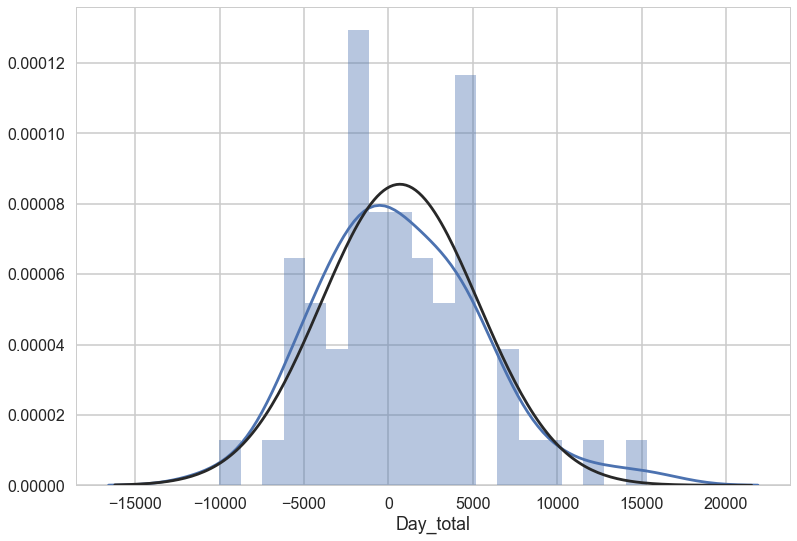

In [875]:
#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);


Winter:

In [876]:
X = all_data[all_data['season'] == 'winter'].drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'Precip(in)'], axis =1)
y = all_data[all_data['season'] == "winter"]['sqrt_Day_total']
df_compiled = pd.DataFrame(columns = ["Train_Score", "Test_Score", "MSE", 'polynomial_degree', "alpha", 'estimator'])


for polynomial_degree in range(0,8):
    print("Degree:", polynomial_degree)
    df_coeff, Error_metrics = regression_check(X, y, polynomial_degree, False)
    headings = Error_metrics.keys()
    df_compiled = pd.concat([df_compiled,pd.DataFrame(Error_metrics.values(), index=headings, columns = ["Train_Score", "Test_Score", "MSE",'polynomial_degree', "alpha",'estimator'])])
    df_coeff[(df_coeff <0.000000001)] = np.nan
    print("# of features = ", df_coeff.shape[0])
    print(df_coeff.isnull().sum())

df_compiled = df_compiled.sort_values(by = "Test_Score", axis = 0, ascending = False)
best_degree = df_compiled.iloc[0]['polynomial_degree']
best_alpha = df_compiled.iloc[0]['alpha']
best_model = df_compiled.iloc[0]['estimator']


Degree: 0
# of features =  1
Feature_Names     0
OLS               1
HuberRegressor    0
ElasticNetCV      1
LassoCV           1
RidgeCV           1
dtype: int64
Degree: 1
# of features =  6
Feature_Names     0
OLS               5
HuberRegressor    4
ElasticNetCV      5
LassoCV           5
RidgeCV           5
dtype: int64
Degree: 2
# of features =  21
Feature_Names      0
OLS                8
HuberRegressor    14
ElasticNetCV      14
LassoCV           14
RidgeCV           11
dtype: int64
Degree: 3
# of features =  56
Feature_Names      0
OLS               27
HuberRegressor    34
ElasticNetCV      27
LassoCV           38
RidgeCV           29
dtype: int64
Degree: 4
# of features =  126
Feature_Names       0
OLS                73
HuberRegressor     89
ElasticNetCV       79
LassoCV           104
RidgeCV            64
dtype: int64
Degree: 5
# of features =  252
Feature_Names       0
OLS               117
HuberRegressor    169
ElasticNetCV      172
LassoCV           225
RidgeCV           149

In [877]:
df_compiled.head(10)

Train_Score  Test_Score         MSE  polynomial_degree  \
LassoCV_7          0.806030    0.693751  538.713410                7.0   
LassoCV_6          0.805520    0.691362  542.915483                6.0   
ElasticNetCV_6     0.804607    0.688563  547.838910                6.0   
ElasticNetCV_7     0.807088    0.688184  548.504889                7.0   
RidgeCV_5          0.802871    0.687462  549.776068                5.0   
ElasticNetCV_2     0.777103    0.686342  551.744897                2.0   
RidgeCV_6          0.806415    0.686303  551.813828                6.0   
RidgeCV_7          0.808721    0.685758  552.772540                7.0   
ElasticNetCV_4     0.801412    0.685171  553.805761                4.0   
ElasticNetCV_5     0.806321    0.684267  555.394734                5.0   

                 alpha                                          estimator  
LassoCV_7        0.005  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
LassoCV_6        0.005  LassoCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_6  0.0001  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
ElasticNetCV_7  0.0001  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
RidgeCV_5        0.005  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_2   5e-05  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
RidgeCV_6        0.005  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
RidgeCV_7        0.005  RidgeCV(alphas=[1e-07, 5e-06, 1e-05, 5e-05, 0....  
ElasticNetCV_4   5e-05  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...  
ElasticNetCV_5   5e-05  ElasticNetCV(alphas=[1e-07, 5e-06, 1e-05, 5e-0...

Train: 0.783488798974
Test: 0.747611681771
alpha =: 0.005
Coefficients are:                           Feature_Names  Coefficients
0                                     1      0.000000
1                              temp avg     -0.000000
2                              avg wind    374.755314
3                            Precip_cat   -170.905076
4                                 month      0.000000
5                           day_of_week      0.000000
6                            temp avg^2     55.340239
7                     temp avg avg wind     39.726495
8                   temp avg Precip_cat     -0.000000
9                        temp avg month      0.000000
10                 temp avg day_of_week      0.000000
11                           avg wind^2     -0.000000
12                  avg wind Precip_cat     -0.000000
13                       avg wind month      0.000000
14                 avg wind day_of_week    226.240731
15                         Precip_cat^2     -0.000000
16    

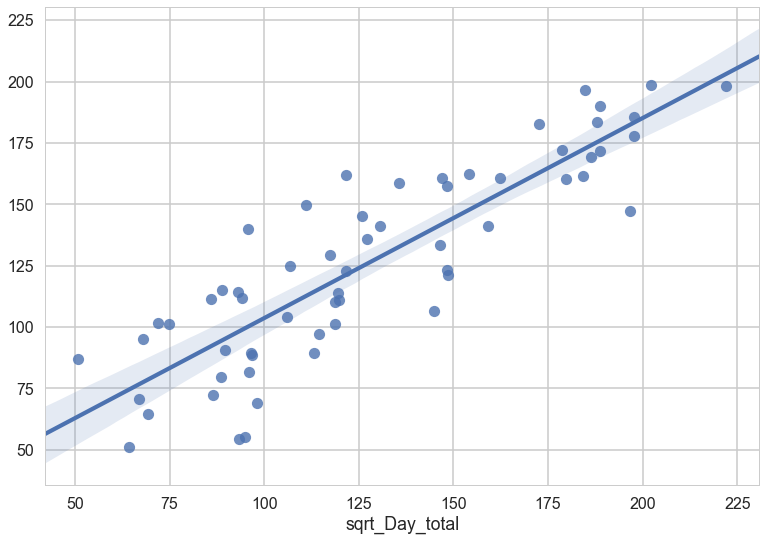

In [878]:
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)

#Get feature names
name = PolynomialFeatures(degree = int(best_degree), interaction_only=False).fit(X_train)
features = name.get_feature_names(X.columns)

reg = LassoCV(alphas=[best_alpha])
model = make_pipeline(PolynomialFeatures(degree = int(best_degree),interaction_only=False ), reg)
fit = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_test, y=y_pred)

# Print out the R^2 for the model against the test dataset
print("Train:", model.score(X_train,y_train))
print("Test:", model.score(X_test,y_test))

df_model_coeff = pd.DataFrame()
df_model_coeff['Feature_Names'] = features
df_model_coeff["Coefficients"] = reg.coef_
print("alpha =:", reg.alpha_)
print("Coefficients are:", df_model_coeff)

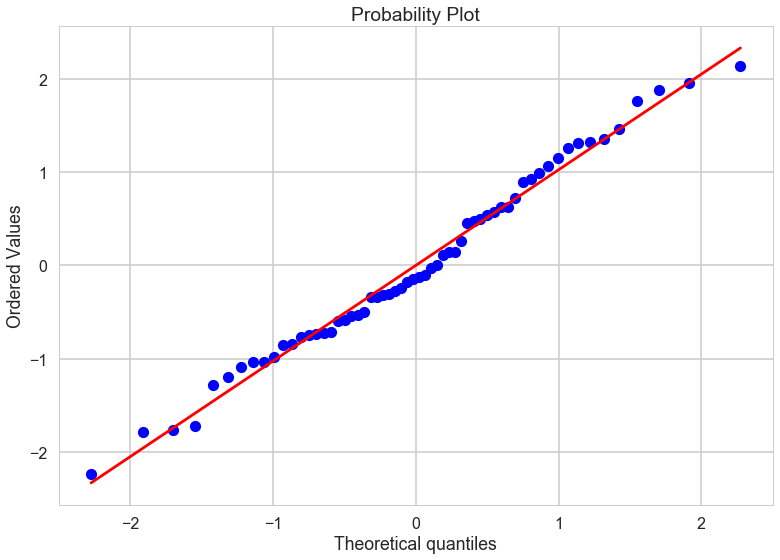

Feature = temp avg


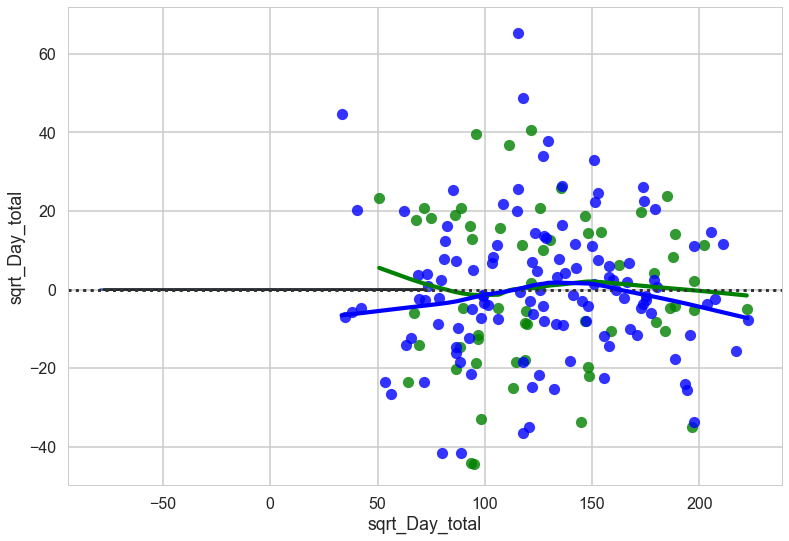

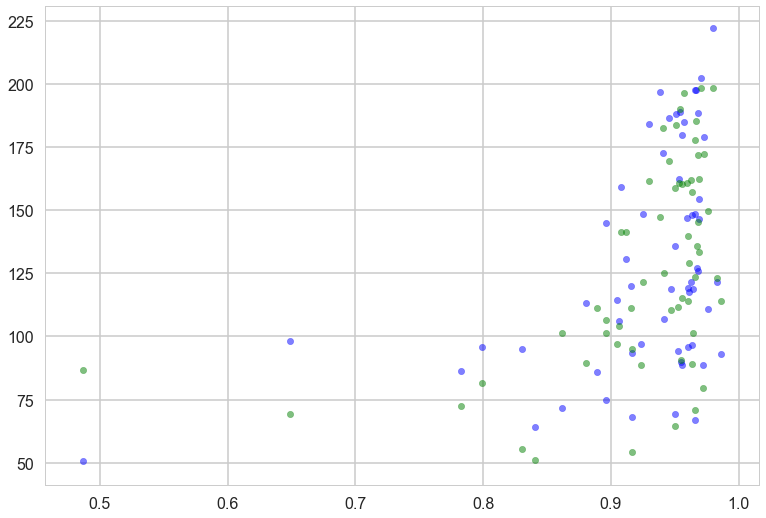

Feature = avg wind


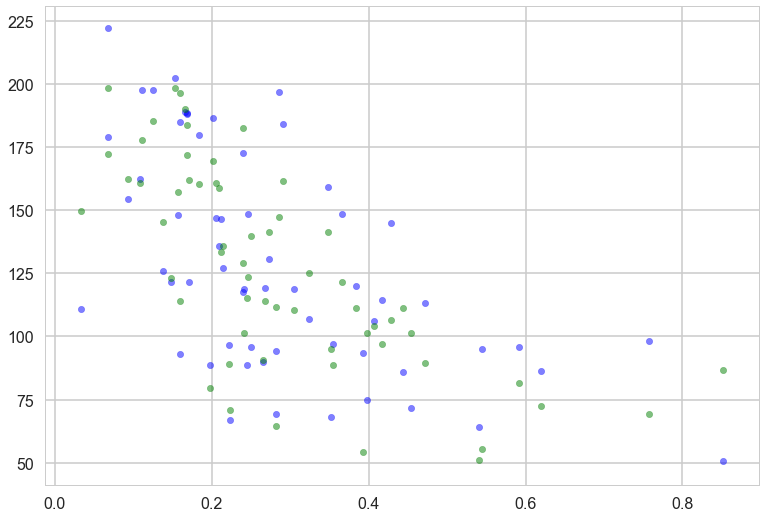

Feature = Precip_cat


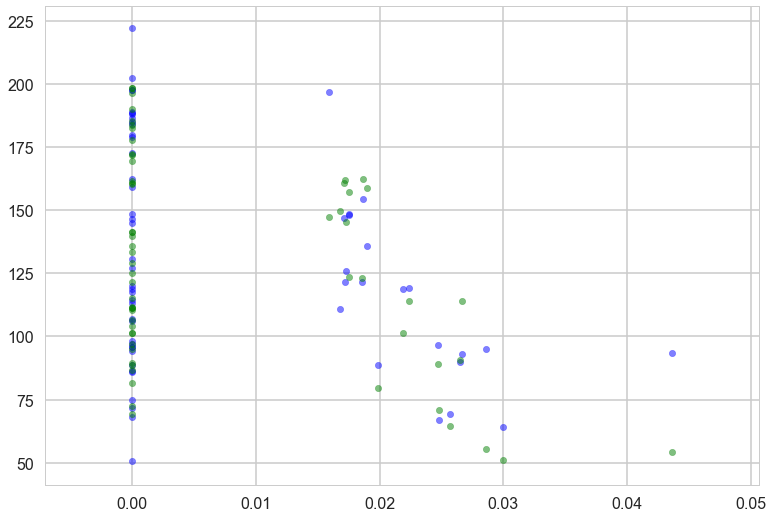

Feature = month


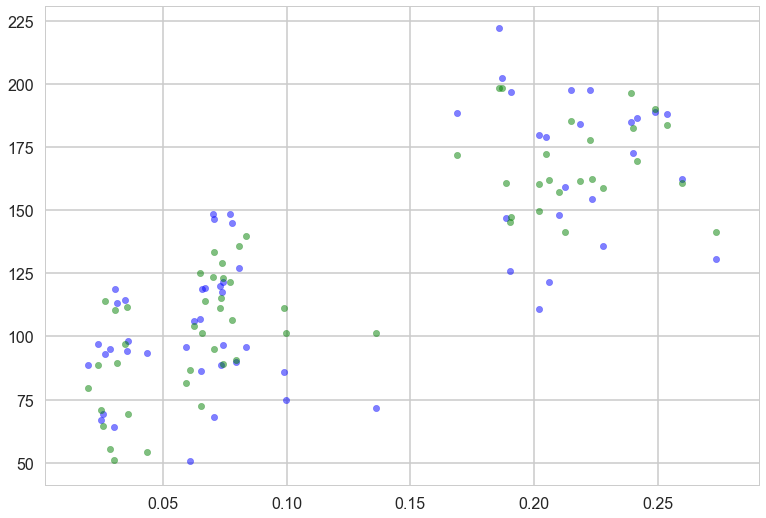

Feature = day_of_week


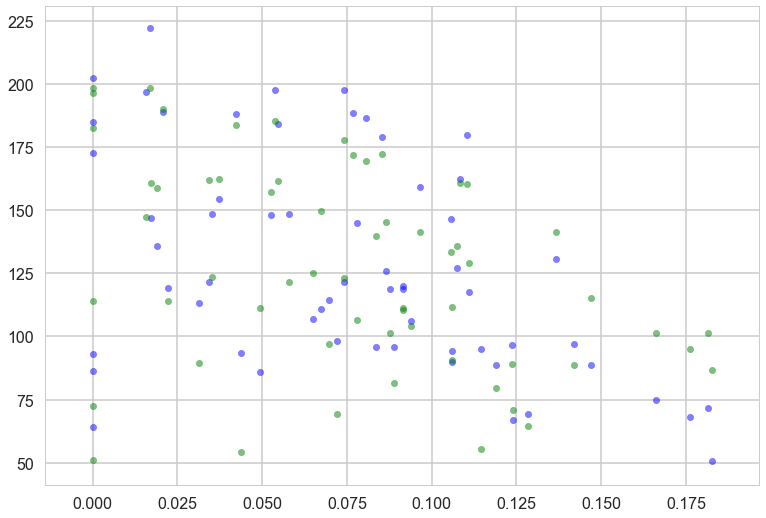

In [879]:
residuals_te = y_pred-y_test
residuals_tr = model.predict(X_train)-y_train

#probplot:
obs = residuals_te
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm",plot=pylab)
pylab.show()


#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);



#residuals trend
sns.residplot(y_test, residuals_te, lowess=True, color="g")
sns.residplot(y_train, residuals_tr, lowess=True, color="b")


for var in range(0, X.shape[1]):
    print("Feature =", X.columns[var])
    plt.figure()
    plt.scatter(X_test[:,var], y_test, c="b", s=40, alpha = 0.5)
    plt.scatter(X_test[:,var], y_pred, c="g", s=40, alpha = 0.5)
    plt.show()

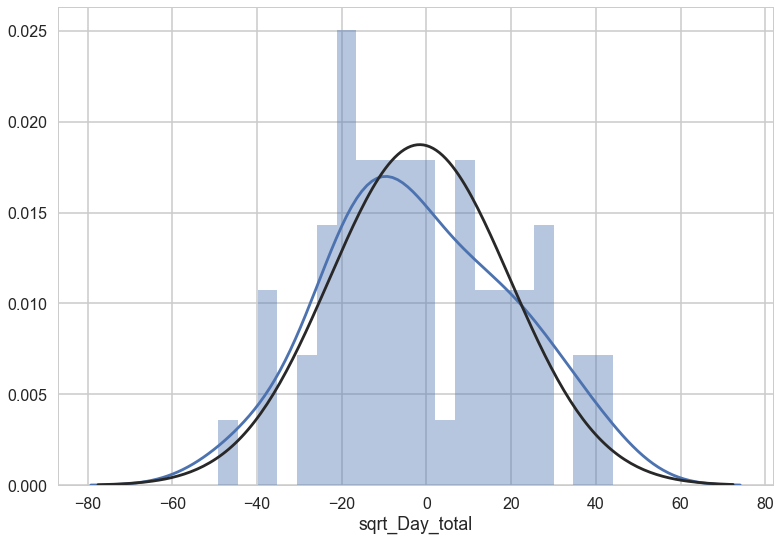

In [880]:
#histogram
sns.distplot(residuals_te, bins = 20,fit=stats.norm);


We can see that breaking up the model doesn't improve it. Our best model is still the 4th degree polynomial features with the model keeping daily average temperature and grouping precipitaion into either "yes" or "no" fitted with a LassoCV model. 

## Part VI) Just pick a model already!!

Our best model is still the 4th degree polynomial features with the model keeping daily average temperature and grouping precipitaion into either "yes" or "no" fitted with a LassoCV model.

Things I could add to this noetbook if I get bored:

What next? 
Try tests for heteroskedacity: https://datascienceplus.com/how-to-detect-heteroscedasticity-and-rectify-it/

https://www.r-bloggers.com/how-to-detect-heteroscedasticity-and-rectify-it/

https://stats.stackexchange.com/questions/68710/heteroskedasticity-residual-plot-interpretation